* [Yelp, Not Kaggle Data Source](https://www.yelp.com/dataset/download)
* [Data Dictionary](https://www.yelp.com/dataset/documentation/main)

* [x] Get data into csv to work in pandas
* [x] Perform sentiment classification with Hugging Face model (2024 SOTA)
* [x] Extract from text key words that resulted in sentiment class (aspect-based sentiment analysis)
* [x] topic modeling
* [ ] other advanced analytics for reviews using LLM/HuggingFace
* [ ] compare competition side-by-side (Japanese restaurants)
* [ ] get criteria for ranking/qualities in restaurant based on aggregation of common words through clustering

In [1]:
!pip install duckdb jupysql -q transformers torch bertopic pyabsa --quiet  
!python -m spacy download en_core_web_md --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
# Computation Status Bar
from tqdm.notebook import tqdm
tqdm.pandas()

# Data Processing
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP Processing and Model Inference
from nltk.corpus import stopwords
import torch
import nltk

## Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

# Topic Modeling
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim import corpora
from gensim.models.ldamodel import LdaModel

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

Deploy Shiny apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-06-11 16:02:50.556514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 16:02:50.556651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 16:02:50.703304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-06-11 16:04:01] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [3]:
dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')
dfr.head()

/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",
/tmp/ipykernel_18/3121522079.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')


,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and 

In [4]:
# dfr['categories'].value_counts()[:20]                                                                           

In [5]:
# Need to clean up category data

query = """
select business_id
, name
, address
, city
, state
, postal_code
, latitude
, longitude
, stars
, review_count
, attributes
, case when categories = 'Mexican, Restaurants' then 'Restaurants, Mexican'
when categories = 'Pizza, Restaurants' then 'Restaurants, Pizza'
when categories = 'Chinese, Restaurants' then 'Restaurants, Chinese'
when categories = 'Italian, Restaurants' then 'Restaurants, Italian'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'American (New), Restaurants' then 'Restaurants, American (New)'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'Vietnamese, Restaurants' then 'Restaurants, Vietnamese'
when categories = 'Cajun/Creole, Restaurants' then 'Restaurants, Cajun/Creole'
else categories
end as categories
, review_id
, user_id
, review_stars
, text
, date
from dfr
"""

dfr = duckdb.query(query).df()
dfr['categories'].value_counts()[:20]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

categories
Restaurants, Mexican                                                                                     88958
Restaurants, Pizza                                                                                       49803
Restaurants, Chinese                                                                                     40040
Restaurants, Italian                                                                                     39086
Restaurants, Thai                                                                                        23803
Restaurants, American (New)                                                                              22206
Restaurants, Seafood                                                                                     20771
Restaurants, Vietnamese                                                                                  15508
Restaurants, Cajun/Creole                                                                            

In [6]:
# dfr['categories'].value_counts()[:20]

In [7]:
query = """
select review_id
, review_stars
, text
from dfr
"""

df_sent2 = duckdb.query(query).df()
df_sent2

,review_id,review_stars,text
0,BXQcBN0iAi1lAUxibGLFzA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area."
1,uduvUCvi9w3T2bSGivCfXg,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town."
2,a0vwPOqDXXZuJkbBW2356g,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite."
3,MKNp_CdR2k2202-c8GN5Dw,5.0,I ordered a graduation cake for my niece and it came out absolutely perfect. Will come again for future events! Staff was nice also and the cake was really good.
4,D1GisLDPe84Rrk_R4X2brQ,4.0,"HK-STYLE MILK TEA: FOUR STARS\n\nNot quite sure why there are two Saint Honore Pastries business listings on Yelp, but I have been checking in to this one.\n\nBoyfriend and I go by it all the time while in Chinatown, but it never crossed our mind to try it. I think we might have tried it once a year or two ago, but it wasn't memorable. I decided to try the HK-style milk tea not too long ago and was hooked. I think I went here almost every day one week to get the milk tea, only to realize that I should REALLY watch my sugar intake...it's sooo good! \n\nI personally don't think it's better than Zhong Gang's HK-style milk tea because they have their off days when a certain lady makes them (not enough ice, too much ice, etc.).\n\nOn a side note: I wanted to try the crispy roast pork bun, but accidentally said the wrong name in Chinese and got the roast pork bun. It was decent enough, although I will get to trying the crispy roast pork bun soon! \n\nI will be back~"
...,...,...,...
3773767,Kt3gFeW1rhZz7RuiV-6Tcw,5.0,"This is my favorite food truck! I only wish I lived closer to Philly so that I could eat here more often. The prices are affordable, the portions are generous, the staff is friendly, and the food is AMAZING. \n\nThe last time I went to the Plum Pit, I ordered a jerk chicken sandwich to split with a friend. Learn from our mistake--order your own sandwich, and if you can't finish it, save half for later. We ended up going back for another sandwich (the one with chicken tenders, mac & cheese, and bacon--I can't remember the name) anyway. We also got two orders of bread pudding to bring home, which, though pretty good cold, is ever better when you heat it up in the oven for 10-15 minutes."
3773768,ruy3Ycey_gGbwkE_3TX1Fg,5.0,"This food truck was stupid. Stupidly delicious. \n\nShould be a 4.5 because they were a little slow compared to other trucks, but once the food showed up, totally ON POINT.\n\nWe had the bacon Mac and cheese with the French fry bowl, topped with jerk chicken. I could not get enough of the jerk chicken. And the bacon Mac and cheese was super creamy ( again 4.5 we saw a big can of nacho cheese instead of good cheese "" . \n\nWould definitely eat here again if they were at the Stables."
3773769,C_l8NTpvNOEUorEmEOusaA,5.0,Bubba never disappoints i go to his fb page and hunt him down and now i have my friends and family stalking him too. One of the main r

In [8]:
# reduce file size by getting sample
#sample 500,000 to use less RAM
sample = df_sent2.sample(n=500000)
len(sample)

500000

In [9]:
# sample.head(1)

# Text Pre-Processing

In [10]:
# text column needs to be changed to string...
sample['text'] = sample['text'].apply(str)

In [11]:
# Get code to clean text: remove HTML tags
def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', '')
    
sample['clean_text'] = sample.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
sample

,review_id,review_stars,text,clean_text
1538419,ugYj2nPPQVRClsVK6H318w,5.0,Good food and very courteous staff I had the chicken Parmesan my wife had a chicken wrap and the kids had grilled cheese and French fries food was great and our waitress even surprised my kids with cupcakes which I think was very nice... and not to mention on the way out the hostess even gave us a box of cookies to take home... this is a great diner family owned and operated would definitely recommend to anyone,Good food and very courteous staff I had the chicken Parmesan my wife had a chicken wrap and the kids had grilled cheese and French fries food was great and our waitress even surprised my kids with cupcakes which I think was very nice... and not to mention on the way out the hostess even gave us a box of cookies to take home... this is a great diner family owned and operated would definitely recommend to anyone
183042,qBLd1fo4Ze5ohIseSLoF5Q,5.0,"I was so impressed by this place! We came for brunch one weekend and I'm so glad we did. The ambiance is absolutely stunning- high ceilings, beautiful decor. The food and drinks were equally as incredible. We had the Lebanese chai latte and the mule, both of which were unique and delicious. The menu has many things that all sound amazing, but we finally decided on a few smaller plates. For the price, the serving sizes were more than enough, and everything had so much wonderful flavor. I can't wait to come back and try everything they have, including their dinner menu. Highly recommend!","I was so impressed by this place! We came for brunch one weekend and I'm so glad we did. The ambiance is absolutely stunning- high ceilings, beautiful decor. The food and drinks were equally as incredible. We had the Lebanese chai latte and the mule, both of which were unique and delicious. The menu has many things that all sound amazing, but we finally decided on a few smaller plates. For the price, the serving sizes were more than enough, and everything had so much wonderful flavor. I can't wait to come back and try everything they have, including their dinner menu. Highly recommend!"
2078459,I_RNvUu5rUTHanJNmAFxRA,5.0,"Absolutely love this place. The price is reasonable in my opinion. About $10-12 per person. The bread is yummy. They cater, too!!","Absolutely love this place. The price is reasonable in my opinion. About $10-12 per person. The bread is yummy. They cater, too!!"
609128,1_jVQuvs4zqdxyZ7Q9xjqg,3.0,"Isn't my favorite. Noodles were broken, and too much oil when I asked for little to no oil. I was told that they couldn't do that which surprised me.","Isn't my favorite. Noodles were broken, and too much oil when I asked for little to no oil. I was told that they couldn't do that which surprised me."
2886661,5jpPYxdALlMavV37Vc033g,5.0,"Oh yeah. That's all I can say!! Very busy but service is very fast and food is fresh and oh good. Beware... this is a CASH ONLY establishment however, there is an ATM is inside the building though. The Street Corn is outstanding. We could eat there everyday. Best Street Taco's around.","Oh yeah. That's all I can say!! Very busy but service is very fast and food is fresh and oh good. Beware... this is a CASH ONLY establishment however, there is an ATM is inside the building though. The Street Corn is outstanding. We could eat there everyday. Best Street Taco's around."
...,...,...,...,...
1239779,U_uDXIe8_J00hRvwNe7MSg,1.0,"Came here on for a late lunch on a Sunday with my parents. It took over an hour for our food to arrive. We couldn't find our server for most of the time. She never refilled our drinks, we had to chase down someone else working there for a refill. She never came back to check on us once the food came (and never apologized for it taking so long). I had to ask the hostess for our check. Terrible experience and don't eat here if you're a Celiac. They don't accommodate, I've gotten sick the two times I've eaten here.","Came here on for a late lunch on a Sunday with 

In [12]:
# normalize text by lowering it all
sample['clean_text'] = sample['clean_text'].str.lower()

In [13]:
%%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 500 total words as max length since tokenizer can add suffixes as a token
#2. eliminate tokens lengths greater than max/summarize text using chatgpt?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# sentence = "Sentence to check whether it exceeds 512 tokens"

# tokenized_sentence = tokenizer.tokenize(sentence)

# print(len(sentence.split()))  # here is the default length of the sentence
# print(len(tokenized_sentence)) # here is the tokenized length

## Example applied to df

sample['num_tokens_tok'] = sample.apply(lambda row: len(tokenizer.tokenize(row.clean_text)), axis = 1)
sample.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (765 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 5min 43s, sys: 97.3 ms, total: 5min 43s
Wall time: 5min 43s


,review_id,review_stars,text,clean_text,num_tokens_tok
1538419,ugYj2nPPQVRClsVK6H318w,5.0,Good food and very courteous staff I had the chicken Parmesan my wife had a chicken wrap and the kids had grilled cheese and French fries food was great and our waitress even surprised my kids with cupcakes which I think was very nice... and not to mention on the way out the hostess even gave us a box of cookies to take home... this is a great diner family owned and operated would definitely recommend to anyone,good food and very courteous staff i had the chicken parmesan my wife had a chicken wrap and the kids had grilled cheese and french fries food was great and our waitress even surprised my kids with cupcakes which i think was very nice... and not to mention on the way out the hostess even gave us a box of cookies to take home... this is a great diner family owned and operated would definitely recommend to anyone,90
183042,qBLd1fo4Ze5ohIseSLoF5Q,5.0,"I was so impressed by this place! We came for brunch one weekend and I'm so glad we did. The ambiance is absolutely stunning- high ceilings, beautiful decor. The food and drinks were equally as incredible. We had the Lebanese chai latte and the mule, both of which were unique and delicious. The menu has many things that all sound amazing, but we finally decided on a few smaller plates. For the price, the serving sizes were more than enough, and everything had so much wonderful flavor. I can't wait to come back and try everything they have, including their dinner menu. Highly recommend!","i was so impressed by this place! we came for brunch one weekend and i'm so glad we did. the ambiance is absolutely stunning- high ceilings, beautiful decor. the food and drinks were equally as incredible. we had the lebanese chai latte and the mule, both of which were unique and delicious. the menu has many things that all sound amazing, but we finally decided on a few smaller plates. for the price, the serving sizes were more than enough, and everything had so much wonderful flavor. i can't wait to come back and try everything they have, including their dinner menu. highly recommend!",130
2078459,I_RNvUu5rUTHanJNmAFxRA,5.0,"Absolutely love this place. The price is reasonable in my opinion. About $10-12 per person. The bread is yummy. They cater, too!!","absolutely love this place. the price is reasonable in my opinion. about $10-12 per person. the bread is yummy. they cater, too!!",33
609128,1_jVQuvs4zqdxyZ7Q9xjqg,3.0,"Isn't my favorite. Noodles were broken, and too much oil when I asked for little to no oil. I was told that they couldn't do that which surprised me.","isn't my favorite. noodles were broken, and too much oil when i asked for little to no oil. i was told that they couldn't do that which surprised me.",37
2886661,5jpPYxdALlMavV37Vc033g,5.0,"Oh yeah. That's all I can say!! Very busy but service is very fast and food is fresh and oh good. Beware... this is a CASH ONLY establishment however, there is an ATM is inside the building though. The Street Corn is outstanding. We could eat there everyday. Best Street Taco's around.","oh yeah. that's all i can say!! very busy but service is very fast and food is fresh and oh good. beware... this is a cash only establishment however, there is an atm is inside the building though. the street corn is outstanding. we could eat there everyday. best street taco's around.",70


In [14]:
# get rid of rows that are <450 words in length since this tokenizer is approx of tokenizer used for sentiment model
query = """
select *
from sample
where num_tokens_tok < 450
"""

sample_short_rev = duckdb.query(query).df()
sample_short_rev.head()

,review_id,review_stars,text,clean_text,num_tokens_tok
0,ugYj2nPPQVRClsVK6H318w,5.0,Good food and very courteous staff I had the chicken Parmesan my wife had a chicken wrap and the kids had grilled cheese and French fries food was great and our waitress even surprised my kids with cupcakes which I think was very nice... and not to mention on the way out the hostess even gave us a box of cookies to take home... this is a great diner family owned and operated would definitely recommend to anyone,good food and very courteous staff i had the chicken parmesan my wife had a chicken wrap and the kids had grilled cheese and french fries food was great and our waitress even surprised my kids with cupcakes which i think was very nice... and not to mention on the way out the hostess even gave us a box of cookies to take home... this is a great diner family owned and operated would definitely recommend to anyone,90
1,qBLd1fo4Ze5ohIseSLoF5Q,5.0,"I was so impressed by this place! We came for brunch one weekend and I'm so glad we did. The ambiance is absolutely stunning- high ceilings, beautiful decor. The food and drinks were equally as incredible. We had the Lebanese chai latte and the mule, both of which were unique and delicious. The menu has many things that all sound amazing, but we finally decided on a few smaller plates. For the price, the serving sizes were more than enough, and everything had so much wonderful flavor. I can't wait to come back and try everything they have, including their dinner menu. Highly recommend!","i was so impressed by this place! we came for brunch one weekend and i'm so glad we did. the ambiance is absolutely stunning- high ceilings, beautiful decor. the food and drinks were equally as incredible. we had the lebanese chai latte and the mule, both of which were unique and delicious. the menu has many things that all sound amazing, but we finally decided on a few smaller plates. for the price, the serving sizes were more than enough, and everything had so much wonderful flavor. i can't wait to come back and try everything they have, including their dinner menu. highly recommend!",130
2,I_RNvUu5rUTHanJNmAFxRA,5.0,"Absolutely love this place. The price is reasonable in my opinion. About $10-12 per person. The bread is yummy. They cater, too!!","absolutely love this place. the price is reasonable in my opinion. about $10-12 per person. the bread is yummy. they cater, too!!",33
3,1_jVQuvs4zqdxyZ7Q9xjqg,3.0,"Isn't my favorite. Noodles were broken, and too much oil when I asked for little to no oil. I was told that they couldn't do that which surprised me.","isn't my favorite. noodles were broken, and too much oil when i asked for little to no oil. i was told that they couldn't do that which surprised me.",37
4,5jpPYxdALlMavV37Vc033g,5.0,"Oh yeah. That's all I can say!! Very busy but service is very fast and food is fresh and oh good. Beware... this is a CASH ONLY establishment however, there is an ATM is inside the building though. The Street Corn is outstanding. We could eat there everyday. Best Street Taco's around.","oh yeah. that's all i can say!! very busy but service is very fast and food is fresh and oh good. beware... this is a cash only establishment however, there is an atm is inside the building though. the street corn is outstanding. we could eat there everyday. best street taco's around.",70


In [15]:
#Check max number tokens
# query = """
# select max(num_tokens_tok) as max_tokens
# from sample_short_rev
# """

# duckdb.query(query).df()

In [16]:
# remaining of sample after token length filter
# len(sample_short_rev)

# Sentiment Classification

In [17]:
# using Hugging Face sentiment classifier trained on Yelp restaurant reviews

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="mrcaelumn/yelp_restaurant_review_sentiment_analysis")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [18]:
test = sample_short_rev.sample(n=5000)

In [19]:
%%time

test = (
test.assign(sentiment = lambda x: x['clean_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

test.head()

CPU times: user 17min 53s, sys: 1.86 s, total: 17min 55s
Wall time: 8min 58s


,review_id,review_stars,text,clean_text,num_tokens_tok,sentiment,label,score
220515,kFoOII_F3jnIQicfCU3GYQ,5.0,"I have enjoyed sushi for a long time. My favorite was Kokopelli's at Circus Circus. I have experiences at other places such as sushi pier, hiroba etc... However, I didn't notice this place before I received the advertised mail. I was very surprised at the wonderful sushi provided at this restaurant. For the nigiri, I cannot give them 5 stars. The amount of rice in nigiri is a little higher compared to raw fish amount. Kokopelli's is the best for nigiri. However, I will give five stars to this restaurant. The rolls are the best.. The ratio of rice and contents are very good for taste. Generally, the quality of raw fish is very good. The price is highly competitive in those good quality of food. \nTheir friendly service, short wait time for food, and other extras such as free beer, alcohol, and VIP promotions are perfect additional benefits to their customers!\n\nI am very happy to have this wonderful place near my home.","i have enjoyed sushi for a long time. my favorite was kokopelli's at circus circus. i have experiences at other places such as sushi pier, hiroba etc... however, i didn't notice this place before i received the advertised mail. i was very surprised at the wonderful sushi provided at this restaurant. for the nigiri, i cannot give them 5 stars. the amount of rice in nigiri is a little higher compared to raw fish amount. kokopelli's is the best for nigiri. however, i will give five stars to this restaurant. the rolls are the best.. the ratio of rice and contents are very good for taste. generally, the quality of raw fish is very good. the price is highly competitive in those good quality of food. their friendly service, short wait time for food, and other extras such as free beer, alcohol, and vip promotions are perfect additional benefits to their customers! i am very happy to have this wonderful place near my home.",211,"[{'label': 'LABEL_2', 'score': 0.9945166707038879}]",LABEL_2,0.994517
308824,nvHUD0VF-3aGullgbnnFTw,3.0,"I enjoy their white rice dishes and banh mi. Their thai short ribs are amazingly good. The banh mi was good as well, but not the best I've had. I didn't however enjoy anything else they had to offer on their menu. The fried rice was a too salty and not enough meat for a combination dish. The same can be said about their bird nest (crunchy fried noodles with combinations of meat and veggies on top. The waitress was kind and very helpful. I would go back just for those 2 dishes though, so it wasn't a bad experience.","i enjoy their white rice dishes and banh mi. their thai short ribs are amazingly good. the banh mi was good as well, but not the best i've had. i didn't however enjoy anything else they had to offer on their menu. the fried rice was a too salty and not enough meat for a combination dish. the same can be said about their bird nest (crunchy fried noodles with combinations of meat and veggies on top. the waitress was kind and very helpful. i would go back just for those 2 dishes though, so it wasn't a bad experience.",122,"[{'label': 'LABEL_1', 'score': 0.8959347009658813}]",LABEL_1,0.895935
384361,oooLkjp3Eqo4RcuxhhGiPw,5.0,"We enjoyed the buffet on Sunday $10.95 per person. Excellent value for the quality and variety. Servers were friendly and I liked the ambience and decor. I've visited here a few more times, including 2x in which I got the ""buffet"" to go. I'll continue to eat here, because they have good options for those of us who do not eat meat. Other places offer limited selections. Special request to the owners - can you offer the option of sauce made with coconut milk, as opposed to dairy? I am allergic to casein and I eat yummy food with it knowing I'll suffer, but do it anyway sometimes when the food is delicious!","we enjoyed the buffet on sunday $10.95 per person. excellent value for the quality and variety. servers were friendly and i liked the ambience an

In [20]:
# Sentiment Label Breakdown
# test['label'].value_counts() # Mostly positive reviews

In [21]:
# LABEL_0 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_0'
# """

# label_0 = duckdb.query(query).df()
# label_0.head()

In [22]:
# label_0['review_stars'].value_counts() #for lowest star ratings/negative sentiment

In [23]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_0
# where review_stars >=4
# """

# bad_labels_0 = duckdb.query(query).df()
# bad_labels_0

# labeling check (sampled 6)
1. incorrect rating from model - 5 (0,1,3,4,5)
2. incorrect star rating from user - 1 (2)

In [24]:
# bad_labels_0['score'].describe()

In [25]:
# print('Percentage of bad labels in negative sentiment class:',round(len(bad_labels_0)/len(label_0),2) *100, '%.')

In [26]:
# LABEL_1 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_1'
# """

# label_1 = duckdb.query(query).df()
# label_1.head()

In [27]:
# label_1['review_stars'].value_counts() #suppose to be for neutral. makes sense that 1 and 5 are on the bottom

In [28]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_1
# where review_stars in (1,5)
# """

# bad_labels_1 = duckdb.query(query).df()
# bad_labels_1

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [29]:
# bad_labels_1['score'].describe()

In [30]:
# print('Percentage of bad labels in neutral sentiment class:',round(len(bad_labels_1)/len(label_1),2) *100, '%.')

In [31]:
# LABEL_2 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_2'
# """

# label_2 = duckdb.query(query).df()
# label_2.head()

In [32]:
# label_2['review_stars'].value_counts() # suppose to be for highly positive

In [33]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_2
# where review_stars in (1,2)
# """

# bad_labels_2 = duckdb.query(query).df()
# bad_labels_2

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [34]:
# bad_labels_2['score'].describe() # lower percentage the better since these not good labels from model

In [35]:
# print('Percentage of bad labels in positive sentiment class:',round(len(bad_labels_2)/len(label_2),2) *100, '%.')

Hugging Face Model was still confident in some really bad/really good sentiment reviews,but only <5% for each sentiment class.

## Continuing to work with 'test" dataset (5,000 samples) due to limited CPU

In [36]:
# Changing sentiment labels to ones that make more sense
query = """
select review_id
, review_stars
, clean_text
, case when label = 'LABEL_0' then 'negative'
when label = 'LABEL_1' then 'neutral'
else 'positive'
end as hf_sent_label
, score as hf_sent_score
from test

"""

test2 = duckdb.query(query).df()
test2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score
0,kFoOII_F3jnIQicfCU3GYQ,5.0,"i have enjoyed sushi for a long time. my favorite was kokopelli's at circus circus. i have experiences at other places such as sushi pier, hiroba etc... however, i didn't notice this place before i received the advertised mail. i was very surprised at the wonderful sushi provided at this restaurant. for the nigiri, i cannot give them 5 stars. the amount of rice in nigiri is a little higher compared to raw fish amount. kokopelli's is the best for nigiri. however, i will give five stars to this restaurant. the rolls are the best.. the ratio of rice and contents are very good for taste. generally, the quality of raw fish is very good. the price is highly competitive in those good quality of food. their friendly service, short wait time for food, and other extras such as free beer, alcohol, and vip promotions are perfect additional benefits to their customers! i am very happy to have this wonderful place near my home.",positive,0.994517
1,nvHUD0VF-3aGullgbnnFTw,3.0,"i enjoy their white rice dishes and banh mi. their thai short ribs are amazingly good. the banh mi was good as well, but not the best i've had. i didn't however enjoy anything else they had to offer on their menu. the fried rice was a too salty and not enough meat for a combination dish. the same can be said about their bird nest (crunchy fried noodles with combinations of meat and veggies on top. the waitress was kind and very helpful. i would go back just for those 2 dishes though, so it wasn't a bad experience.",neutral,0.895935
2,oooLkjp3Eqo4RcuxhhGiPw,5.0,"we enjoyed the buffet on sunday $10.95 per person. excellent value for the quality and variety. servers were friendly and i liked the ambience and decor. i've visited here a few more times, including 2x in which i got the ""buffet"" to go. i'll continue to eat here, because they have good options for those of us who do not eat meat. other places offer limited selections. special request to the owners - can you offer the option of sauce made with coconut milk, as opposed to dairy? i am allergic to casein and i eat yummy food with it knowing i'll suffer, but do it anyway sometimes when the food is delicious!",positive,0.966880
3,ZTAQheQZeNqinnZGPSaHmw,4.0,"locally grown products, offer great healthier options. i loved my elevated egg sandwich - a well-made sandwich that looked appetizing, a great combination of flavor of arugula, bacon, avocado, egg, cheese on a very soft bun. the potatoes on the side was just okay. wasn't sure what the cook was going for, it was neither soft or crispy. so it seemed it was undercooked either way....but the taste of the egg sandwich makes up for it. they could give more potatoes tho...just sayin'. wife got the pumpkin spice pancake - a fall special. it tasted good, however, we didn't like how it would fall apart thru the middle of the pancake when forking it to my mouth. however......i loved the syrup they provide because it's warm!!!, it comes in a glass bottle.the side of eggs...they could give more also...just sayin'. would i come back again? for sure",positive,0.695692
4,2JwkCBQLZpKeFUH8uzxqyQ,2.0,"so we used to love brocato's and would go after almost every date night. we always got the same things, 3 rum cakes and a napoleon. we went tonight and we were so disappointed. they were either out or no longer carry (unsure, didn't ask), the napoleon. so instead just 4 rum cakes. the rum cakes used to be these really big cakes with a cherry on top for somewhere in the neighborhood of $4/each. my total was always $17 and change. well, now the rum cakes are half the size, with half of a cherry and still, the total was $17 and change. adjust the price and give a full cherry, goodness. we were so disappointed. our first time back since quarantine. and it's likely our last.",negative,0.940685
...,...,...,...,...,...
4995,9oqiRXS8FscX6CFGS_2PDQ,1.0,"if i could give a zero rating i would. i mean we

### Checking to see if Vader sentiment classification is better than Hugging Face's predictions

In [37]:
# Let's see if Vader, popular sentiment score for social texts (tweets with emojoi's, slang, contractions) performs better than Hugging Face's scores
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = test2['clean_text'].apply(analyzer.polarity_scores)

# Docs on how scoring was derived and what it means: https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05

test2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test2['clean_text']]
test2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test2['clean_text']]
test2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test2['clean_text']]
test2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test2['clean_text']]

In [38]:
test2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,kFoOII_F3jnIQicfCU3GYQ,5.0,"i have enjoyed sushi for a long time. my favorite was kokopelli's at circus circus. i have experiences at other places such as sushi pier, hiroba etc... however, i didn't notice this place before i received the advertised mail. i was very surprised at the wonderful sushi provided at this restaurant. for the nigiri, i cannot give them 5 stars. the amount of rice in nigiri is a little higher compared to raw fish amount. kokopelli's is the best for nigiri. however, i will give five stars to this restaurant. the rolls are the best.. the ratio of rice and contents are very good for taste. generally, the quality of raw fish is very good. the price is highly competitive in those good quality of food. their friendly service, short wait time for food, and other extras such as free beer, alcohol, and vip promotions are perfect additional benefits to their customers! i am very happy to have this wonderful place near my home.",positive,0.994517,"{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'compound': 0.9943}",0.9943,0.000,0.725,0.275
1,nvHUD0VF-3aGullgbnnFTw,3.0,"i enjoy their white rice dishes and banh mi. their thai short ribs are amazingly good. the banh mi was good as well, but not the best i've had. i didn't however enjoy anything else they had to offer on their menu. the fried rice was a too salty and not enough meat for a combination dish. the same can be said about their bird nest (crunchy fried noodles with combinations of meat and veggies on top. the waitress was kind and very helpful. i would go back just for those 2 dishes though, so it wasn't a bad experience.",neutral,0.895935,"{'neg': 0.04, 'neu': 0.723, 'pos': 0.237, 'compound': 0.967}",0.9670,0.040,0.723,0.237
2,oooLkjp3Eqo4RcuxhhGiPw,5.0,"we enjoyed the buffet on sunday $10.95 per person. excellent value for the quality and variety. servers were friendly and i liked the ambience and decor. i've visited here a few more times, including 2x in which i got the ""buffet"" to go. i'll continue to eat here, because they have good options for those of us who do not eat meat. other places offer limited selections. special request to the owners - can you offer the option of sauce made with coconut milk, as opposed to dairy? i am allergic to casein and i eat yummy food with it knowing i'll suffer, but do it anyway sometimes when the food is delicious!",positive,0.966880,"{'neg': 0.043, 'neu': 0.78, 'pos': 0.177, 'compound': 0.9354}",0.9354,0.043,0.780,0.177
3,ZTAQheQZeNqinnZGPSaHmw,4.0,"locally grown products, offer great healthier options. i loved my elevated egg sandwich - a well-made sandwich that looked appetizing, a great combination of flavor of arugula, bacon, avocado, egg, cheese on a very soft bun. the potatoes on the side was just okay. wasn't sure what the cook was going for, it was neither soft or crispy. so it seemed it was undercooked either way....but the taste of the egg sandwich makes up for it. they could give more potatoes tho...just sayin'. wife got the pumpkin spice pancake - a fall special. it tasted good, however, we didn't like how it would fall apart thru the middle of the pancake when forking it to my mouth. however......i loved the syrup they provide because it's warm!!!, it comes in a glass bottle.the side of eggs...they could give more also...just sayin'. would i come back again? for sure",positive,0.695692,"{'neg': 0.038, 'neu': 0.808, 'pos': 0.154, 'compound': 0.9654}",0.9654,0.038,0.808,0.154
4,2JwkCBQLZpKeFUH8uzxqyQ,2.0,"so we used to love brocato's and would go after almost every date night. we always got the same things, 3 rum cakes and a napoleon. we went tonight and we were so disappointed. they were either out or no longer carry (unsure, didn't ask), the napoleon. so instead just 4 rum cakes. the rum cakes used to be these really big cakes with a cherry on top for somewhere in the neighborhood of $4/each. my total was alwa

In [39]:
# Get vader sentiment in neat format

# query = """
# select review_id
# , review_stars
# , clean_text
# , hf_sent_label
# , hf_sent_score

# , case when compound <= -0.05 then 'negative'
# when compound > -0.05 and compound <0.05 then 'neutral'
# else 'positive'
# end as vader_sent_label
# , compound as vader_score

# , neg as text_neg_ratio
# , neu as text_neu_ratio
# , pos as text_pos_ratio
# from test2
# """

# test3 = duckdb.query(query).df()
# test3

In [40]:
# Compare sent label breakdown between HF and Vader
# test3['hf_sent_label'].value_counts(normalize=True)

In [41]:
# test3['vader_sent_label'].value_counts(normalize=True)

There are some huge differences in label distributions. Let's take a peek at reviews that had divergent labels see which classifier is more accurate.

In [42]:
# query = """
# select *
# from test3
# where hf_sent_label != vader_sent_label
# """

# label_q = duckdb.query(query).df()
# label_q.head(10)

In [43]:
# len(label_q)/len(test3) # wow, 20% discrepancy 

0. negative
1. negative - HF
2. neutral - HF
3. negative - HF
4. neg 
5. neg- HF
6. neutral - HF
7. neg - HF
8. neg
9. neg - HF

Looks like HF is the winner. Even though Vader had good metrics such as neg/neu/pos ratios within review, its composite score is not accurate. So keeping ratio scores, but discarding Vader's composite scores.

In [44]:
query = """
select * -- exclude (vader_sent_label, vader_score)
from test2 -- test3
"""

test4 = duckdb.query(query).df()
test4

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,kFoOII_F3jnIQicfCU3GYQ,5.0,"i have enjoyed sushi for a long time. my favorite was kokopelli's at circus circus. i have experiences at other places such as sushi pier, hiroba etc... however, i didn't notice this place before i received the advertised mail. i was very surprised at the wonderful sushi provided at this restaurant. for the nigiri, i cannot give them 5 stars. the amount of rice in nigiri is a little higher compared to raw fish amount. kokopelli's is the best for nigiri. however, i will give five stars to this restaurant. the rolls are the best.. the ratio of rice and contents are very good for taste. generally, the quality of raw fish is very good. the price is highly competitive in those good quality of food. their friendly service, short wait time for food, and other extras such as free beer, alcohol, and vip promotions are perfect additional benefits to their customers! i am very happy to have this wonderful place near my home.",positive,0.994517,"{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'compound': 0.9943}",0.9943,0.000,0.725,0.275
1,nvHUD0VF-3aGullgbnnFTw,3.0,"i enjoy their white rice dishes and banh mi. their thai short ribs are amazingly good. the banh mi was good as well, but not the best i've had. i didn't however enjoy anything else they had to offer on their menu. the fried rice was a too salty and not enough meat for a combination dish. the same can be said about their bird nest (crunchy fried noodles with combinations of meat and veggies on top. the waitress was kind and very helpful. i would go back just for those 2 dishes though, so it wasn't a bad experience.",neutral,0.895935,"{'neg': 0.04, 'neu': 0.723, 'pos': 0.237, 'compound': 0.967}",0.9670,0.040,0.723,0.237
2,oooLkjp3Eqo4RcuxhhGiPw,5.0,"we enjoyed the buffet on sunday $10.95 per person. excellent value for the quality and variety. servers were friendly and i liked the ambience and decor. i've visited here a few more times, including 2x in which i got the ""buffet"" to go. i'll continue to eat here, because they have good options for those of us who do not eat meat. other places offer limited selections. special request to the owners - can you offer the option of sauce made with coconut milk, as opposed to dairy? i am allergic to casein and i eat yummy food with it knowing i'll suffer, but do it anyway sometimes when the food is delicious!",positive,0.966880,"{'neg': 0.043, 'neu': 0.78, 'pos': 0.177, 'compound': 0.9354}",0.9354,0.043,0.780,0.177
3,ZTAQheQZeNqinnZGPSaHmw,4.0,"locally grown products, offer great healthier options. i loved my elevated egg sandwich - a well-made sandwich that looked appetizing, a great combination of flavor of arugula, bacon, avocado, egg, cheese on a very soft bun. the potatoes on the side was just okay. wasn't sure what the cook was going for, it was neither soft or crispy. so it seemed it was undercooked either way....but the taste of the egg sandwich makes up for it. they could give more potatoes tho...just sayin'. wife got the pumpkin spice pancake - a fall special. it tasted good, however, we didn't like how it would fall apart thru the middle of the pancake when forking it to my mouth. however......i loved the syrup they provide because it's warm!!!, it comes in a glass bottle.the side of eggs...they could give more also...just sayin'. would i come back again? for sure",positive,0.695692,"{'neg': 0.038, 'neu': 0.808, 'pos': 0.154, 'compound': 0.9654}",0.9654,0.038,0.808,0.154
4,2JwkCBQLZpKeFUH8uzxqyQ,2.0,"so we used to love brocato's and would go after almost every date night. we always got the same things, 3 rum cakes and a napoleon. we went tonight and we were so disappointed. they were either out or no longer carry (unsure, didn't ask), the napoleon. so instead just 4 rum cakes. the rum cakes used to be these really big cakes with a cherry on top for somewhere in the neighborhood of $4/each. my total was alwa

In [45]:
# Sentiment broken down by review stars
# query = """
# select review_stars
# , hf_sent_label
# , count(hf_sent_label) as total_sentiment
# from test4
# group by 1,2
# order by 1,2
# """

# duckdb.query(query).df()

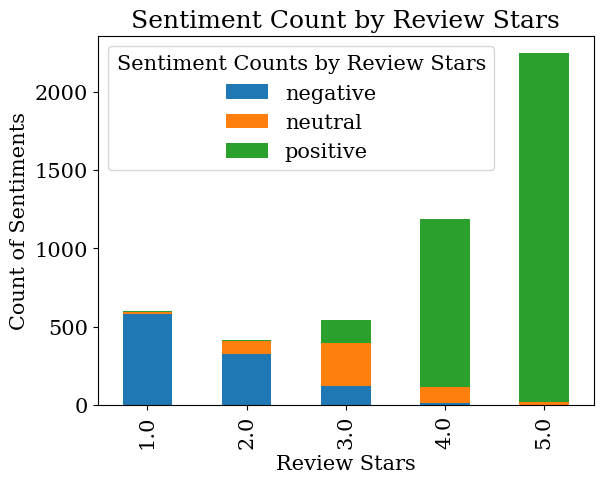

In [46]:
# Aggregate sentiments by review stars
sentiment_counts = test4.groupby(['review_stars', 'hf_sent_label']).size().reset_index(name='total_sentiment')

# Pivot the DataFrame for easier plotting
pivot_df = sentiment_counts.pivot(index='review_stars', columns='hf_sent_label', values='total_sentiment').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Count by Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Count of Sentiments')
plt.legend(title='Sentiment Counts by Review Stars')
plt.show()

This makes a lot of sense since most of the negative sentiment/blue color are in lower ratings and most of the positive sentiment/positive color are in higher ratings with neutral/orange concentrated in center of visualization: rating 3.

In [47]:
# Look at the box plot of sentiment ratios broken down by overall sentiment
# Plot boxplots for text_neg_ratio, text_neu_ratio, and text_pos_ratio broken down by hf_sent_label

# plt.figure(figsize=(15, 5))

# # Plot for text_neg_ratio
# plt.subplot(1, 3, 1)
# sns.boxplot(x='hf_sent_label', y='text_neg_ratio', data=test4)
# plt.title('Boxplot of text_neg_ratio by Sentiment Label')

# # Plot for text_neu_ratio
# plt.subplot(1, 3, 2)
# sns.boxplot(x='hf_sent_label', y='text_neu_ratio', data=test4)
# plt.title('Boxplot of text_neu_ratio by Sentiment Label')

# # Plot for text_pos_ratio
# plt.subplot(1, 3, 3)
# sns.boxplot(x='hf_sent_label', y='text_pos_ratio', data=test4)
# plt.title('Boxplot of text_pos_ratio by Sentiment Label')

# # Adjust layout and show plot
# plt.tight_layout()
# plt.show()

High negative and high positive ratios correspond with neg/pos sentiments. Review sentiment composition gets murky with neutral sentiment since a neutral stance with a restaurant can have a bunch of negative or neutral comments. Would need to look at star rating to get a better view of what sentiment is majority in neutral classified reviews. Let's take a quick peek.

In [48]:
# query = """
# select review_stars
# , clean_text
# , hf_sent_label
# -- , text_neu_ratio
# -- , text_neg_ratio
# -- , text_pos_ratio
# from test4
# where hf_sent_label = 'neutral'
# """

# neutral = duckdb.query(query).df()
# neutral.head(10)

Text mostly is comprised of what:

0. neutral then little neg; neutral ratio correct
1. neg; wrong neg ratio
2. pos and neg (60%); wrong ratio for pos
3. pos, neutral, neg; wrong ratio for pos
4. pos, neg; pos was second
5. neg, pos; neg was low percent
6. neg, pos; neg is lowest ratio
7. pos and neg; pos is higher than neg but neu highest
8. neg, pos; pos has higher ratio than neg but neu highest
9. pos, neg; pos then neg but neu ratio is highest

Mapping review stars to sentiment is difficult because people have varying subjectve definitions for what deserves a 1 versus 5.

In [49]:
# dfr.head()

In [50]:
# Join sample table to dfr to get category and date for review

query = """
select *
from test4
inner join (select review_id as review_id, categories, date from dfr) as dfr
on test4.review_id = dfr.review_id
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date
0,YQ_KTO-kxFfNwASYTUFmLw,1.0,if i could i would give them no stars for this dump . to sit and wait 15 minutes for a table is bull shit when there were a few empty ones . i asked for lemon for my tea but i think they were waiting for the tree to grow . i had to ask the hostess did i have to kill to get a lemon . our waitress was a bartender. she was more interested in making drinks then waiting on us . or 1/2 a rack of baby back ribs. there were so bad that i could have went to macdonald's and got one cheaper and tasted better. i will never ever go back to this dump again . i wouldn't even buy food from here and give to a homeless person. here's to you applebee's kma.,negative,0.989507,"{'neg': 0.17, 'neu': 0.775, 'pos': 0.055, 'compound': -0.9455}",-0.9455,0.170,0.775,0.055,YQ_KTO-kxFfNwASYTUFmLw,"Bars, American (Traditional), Sports Bars, Chicken Wings, Nightlife, Restaurants, Steakhouses, Burgers",2021-07-24 21:52:27
1,CQz8TnjUhtSWEeO-bwx57A,5.0,"our usual chinese restaurant was closed due to the pandemic. we were given this suggestion by a friend. we have now ordered from this restaurant two times. it is definitely a good option to eat from nearby. delivery is quick and easy (35-40mins). the chicken wings are good (fried well) with a great taste. the pork fried rice, shrimp toast, egg rolls and pizza rolls are also tasty. my daughter enjoyed the spare ribs. i would definitely recommend as a chinese food contender in the clementon area.",positive,0.985723,"{'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'compound': 0.9792}",0.9792,0.000,0.715,0.285,CQz8TnjUhtSWEeO-bwx57A,"Restaurants, Chinese",2020-06-21 20:21:04
2,8Ih1Pd1jeo9BWpkd5hIQmA,5.0,they have a kaoroke area! so love this place. food was amazing. enjoyed myself in karaoke area. i will definitely come back.,positive,0.998152,"{'neg': 0.0, 'neu': 0.509, 'pos': 0.491, 'compound': 0.9473}",0.9473,0.000,0.509,0.491,8Ih1Pd1jeo9BWpkd5hIQmA,"Nightlife, Sushi Bars, Karaoke, Restaurants, Seafood",2018-07-28 11:43:46
3,IrntvhsaQrAa8t9xUSbisA,5.0,i'm a pretty picky eater and had never had roasted peppers (and eggplant & tomato) until i had it here as their house appetizer. omg - soooo delicious! their portions are served just right and their main dishes are just sumptuous and paired w/ unlikely things. i love this place. they serve a different menu than the other filomena's but are equally as yummy. give them a try!,positive,0.995226,"{'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'compound': 0.9049}",0.9049,0.000,0.823,0.177,IrntvhsaQrAa8t9xUSbisA,"Restaurants, Italian",2010-03-10 21:50:40
4,-KXb_tQgCzMfQCgtMPYfPA,2.0,"i went there about one year ago and was definitely not pleased with the food and the environment. yelp keep asking about writing the review, so i am writing the review after a long time. not my first choice when i want to eat in fast food chain restaurant. hopefully things get better!",negative,0.919836,"{'neg': 0.043, 'neu': 0.782, 'pos': 0.176, 'compound': 0.7569}",0.7569,0.043,0.782,0.176,-KXb_tQgCzMfQCgtMPYfPA,"Caterers, Mexican, Event Planning & Services, Restaurants, Fast Food",2018-08-27 01:02:13
5,gCJPAQWXxEesL35PL768_A,4.0,"perhaps my expectations were too high, but overall, indo would not make my top 10 go-to in st. louis. i am comparing indo against my stl favorites louie, olive & oak, sidney street, egg, etc. as my experience has been at polite society, things were over-prepared. i prefer to taste the main ingredient and in both cases (indo and polite society), there seems to be too much going on that the main ingredient gets outshined. we had 4 dishes for the 2 of us: lamb ribs (tasty but so much sweetness), tiger shrimp (again, too sweet and under-cooked toward the head), cabbage salad (overall very good but again too sweet) and the biggest disappointment of all the ribeye. it was swimming in soy sauce-based sauce which didn't do anything 

In [51]:
# top categories mentioned in reviews
# test5['categories'].value_counts()

In [52]:
# Sentiment breakdown for category; only work with top 5
query = """
select *
from test5
where categories in ('Restaurants, Mexican', 'Restaurants, Pizza', 'Restaurants, Chinese', 'Restaurants, Italian', 'Restaurants, Seafood')
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date
0,CQz8TnjUhtSWEeO-bwx57A,5.0,"our usual chinese restaurant was closed due to the pandemic. we were given this suggestion by a friend. we have now ordered from this restaurant two times. it is definitely a good option to eat from nearby. delivery is quick and easy (35-40mins). the chicken wings are good (fried well) with a great taste. the pork fried rice, shrimp toast, egg rolls and pizza rolls are also tasty. my daughter enjoyed the spare ribs. i would definitely recommend as a chinese food contender in the clementon area.",positive,0.985723,"{'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'compound': 0.9792}",0.9792,0.000,0.715,0.285,CQz8TnjUhtSWEeO-bwx57A,"Restaurants, Chinese",2020-06-21 20:21:04
1,IrntvhsaQrAa8t9xUSbisA,5.0,i'm a pretty picky eater and had never had roasted peppers (and eggplant & tomato) until i had it here as their house appetizer. omg - soooo delicious! their portions are served just right and their main dishes are just sumptuous and paired w/ unlikely things. i love this place. they serve a different menu than the other filomena's but are equally as yummy. give them a try!,positive,0.995226,"{'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'compound': 0.9049}",0.9049,0.000,0.823,0.177,IrntvhsaQrAa8t9xUSbisA,"Restaurants, Italian",2010-03-10 21:50:40
2,RcrfJEotrvBb8xHloYeq1A,5.0,"awesome italian food, everything on the menu is fabulous. i have never had a bad meal here and i've tried a lot of items from the menu including soups and salads which i don't normally like. today i had the pork ricotta, hands down the best italian meal i've ever had in my life! do yourself a favor and give this place a try.",positive,0.997966,"{'neg': 0.03, 'neu': 0.722, 'pos': 0.248, 'compound': 0.9471}",0.9471,0.030,0.722,0.248,RcrfJEotrvBb8xHloYeq1A,"Restaurants, Italian",2016-08-17 23:36:43
3,fT4xpDpmkU9hKkQQIijTSA,1.0,"cars. parked all over sidewalk, young people hanging around outside smoking blocking entrance, very uninviting. i can see why the previous rating was bad because it seems it is more of a hangout than a place preparing good food.",negative,0.964613,"{'neg': 0.145, 'neu': 0.786, 'pos': 0.069, 'compound': -0.4939}",-0.4939,0.145,0.786,0.069,fT4xpDpmkU9hKkQQIijTSA,"Restaurants, Pizza",2018-09-02 05:14:20
4,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.9554}",0.9554,0.000,0.588,0.412,OheAhyoKB-wPVV4qFqhKew,"Restaurants, Mexican",2015-10-05 00:03:00
5,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"{'neg': 0.08, 'neu': 0.736, 'pos': 0.184, 'compound': 0.964}",0.9640,0.080,0.736,0.184,u1Yzkm1pc_Zu1e4ehncaLg,"Restaurants, Mexican",2016-10-15 01:33:12
6,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. y

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

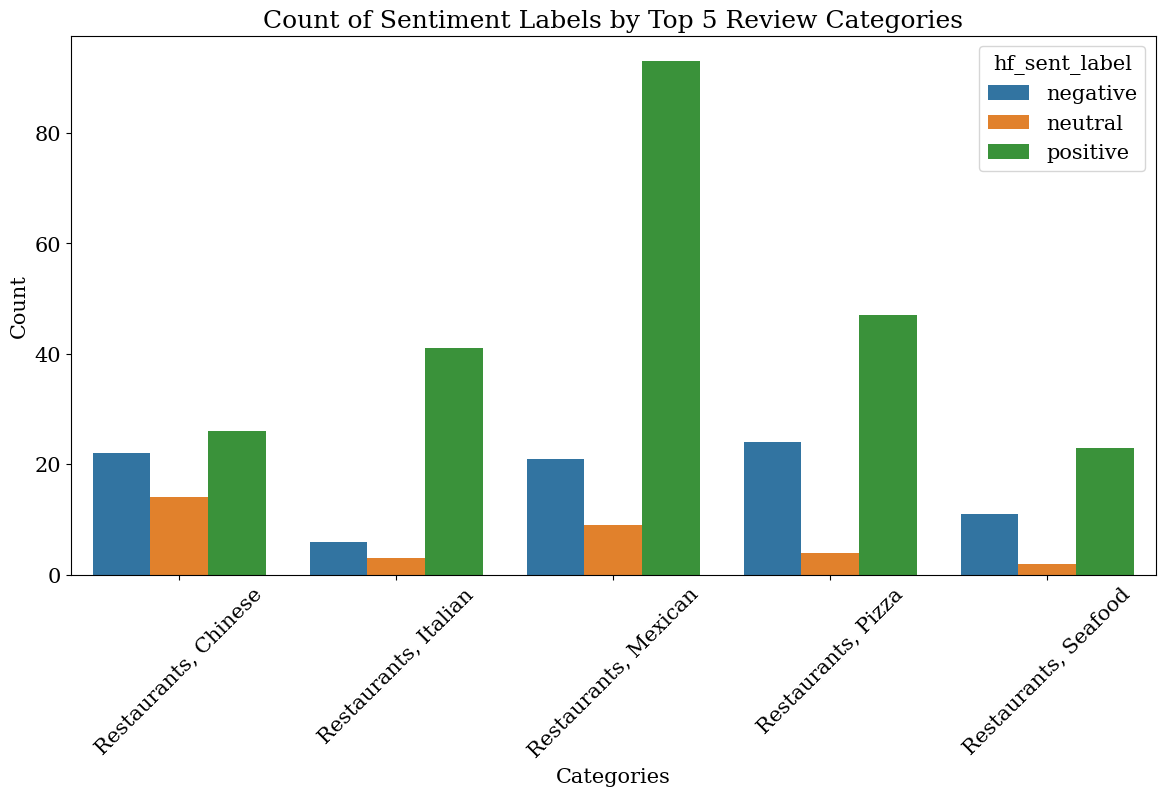

In [53]:
# Group by hf_sent_label and categories and count occurrences
df_grouped = test5.groupby(['hf_sent_label', 'categories']).size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(14, 7))
sns.barplot(x='categories', y='count', hue='hf_sent_label', data=df_grouped)
plt.xticks(rotation=45)
plt.title('Count of Sentiment Labels by Top 5 Review Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

For Mexican Restaurants, positive reviews far outweigh any other cateory.

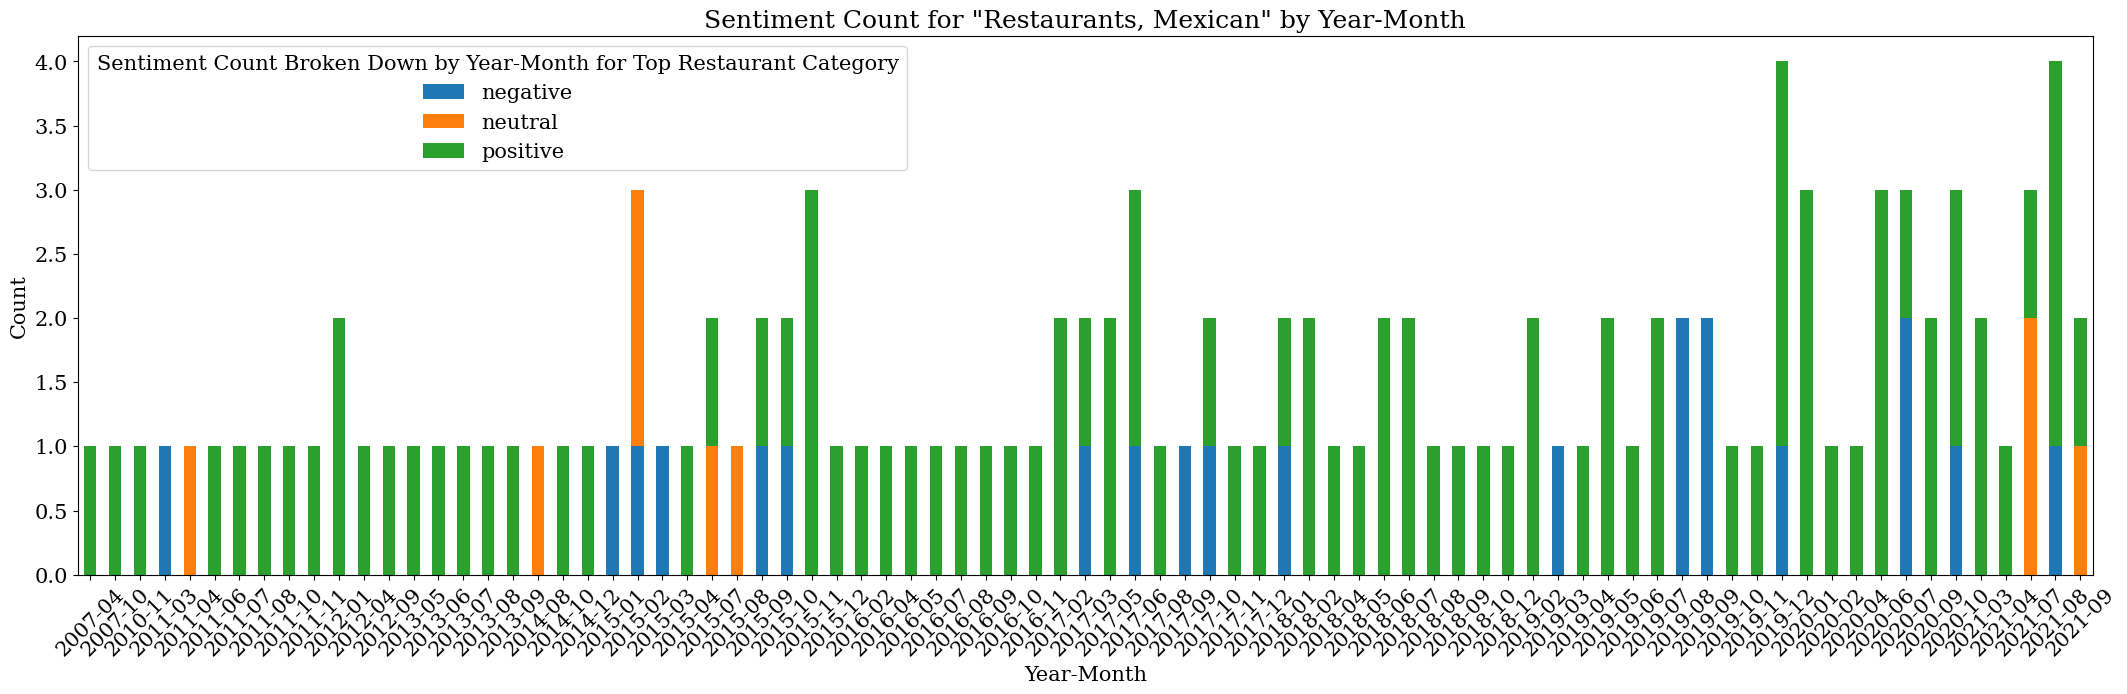

In [54]:
# Sentiment over time for top category: Restaurants, Mexican
# Filter the DataFrame to include only rows where categories is 'Restaurants, Mexican'
df_filtered = test5[test5['categories'] == 'Restaurants, Mexican']

# Convert the date column to datetime
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Extract year and month from the date column
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

# Group by hf_sent_label and year_month and count occurrences
df_grouped = df_filtered.groupby(['hf_sent_label', 'year_month']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='year_month', columns='hf_sent_label', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for "Restaurants, Mexican" by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Count Broken Down by Year-Month for Top Restaurant Category')
plt.show()

Mexican Restaurant category did best in 2018 spring. Would be interesting to focus in on one particular business and see sentiment trend over time.

And of course we want to know what are the reasons for certain sentiments. 
First, let's look at the most talked about topics in these restaurnt reviews.

# Topic Modeling


Extensive pre-processing need to be done because topic modeling cannot interpret all the text noise as well as Hugging Face LLM's can.

In [55]:
test6 = df_filtered.copy()

In [56]:
# Expand contractions and translate common social acronyms

# Dictionary for contractions
contractions_dict = {
    "i've": "I have",
    "can't": "cannot",
    "won't": "will not",
    "i'm": "I am",
    "you're": "you are",
    "you've": "you have",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "you'd": "you would",
    "they'd": "they would",
    "we'd": "we would",
    "she'd": "she would",
    "he'd": "he would",
    "i'd": "I would",
    "it'd": "it would",
    "who'd": "who would",
    "what's": "what is",
    "how's": "how is",
    "let's": "let us",
    "here's": "here is"
}

# Dictionary for social acronyms
acronyms_dict = {
    "lol": "laugh out loud",
    "brb": "be right back",
    "gtg": "got to go",
    "idk": "I do not know",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "afaik": "as far as I know",
    "asap": "as soon as possible",
    "bff": "best friends forever",
    "fyi": "for your information",
    "lmk": "let me know",
    "nvm": "never mind",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the heck",
    "wth": "what the heck",
    "xoxo": "hugs and kisses"
}

# Combine both dictionaries
combined_dict = {**contractions_dict, **acronyms_dict}

# Function to expand contractions and acronyms
def expand_text(text):
    def replace(match):
        return combined_dict[match.group(0).lower()]

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in combined_dict.keys()) + r')\b', re.IGNORECASE)
    expanded_text = pattern.sub(replace, text)
    return expanded_text

# Example usage
# text = "I've been busy lol. IDK what's happening, but can't wait to see you!"
# expanded_text = expand_text(text)
# print(expanded_text)

In [57]:
# given context of reviews, need to translate $ and % amounts into english

# def translate_amounts(text):
#     # Define regex patterns for dollar amounts and percentages
#     dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
#     percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

#     # Replace dollar amounts with "X dollars"
#     text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
#     # Replace percentages with "X percent"
#     text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
#     return text

# Example usage
# text = "The price is $4.00 and the discount is 4%."
# translated_text = translate_amounts(text)
# print(translated_text)  # Output: The price is 4.0 dollars and the discount is 4.0 percent.

In [58]:
# def replace_ampersand(text):
#     return text.replace('&', 'and')

# sentence = 'This is a test for &'
# print(replace_ampersand(sentence))

In [59]:
# def remove_punctuation(text):
#     return re.sub(r'[^\w\s]', '', text)

In [60]:
def more_txt_prep(text):
    # Define regex patterns for dollar amounts and percentages
    dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
    percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

    # Replace dollar amounts with "X dollars"
    text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
    # Replace percentages with "X percent"
    text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
    #replace ampersand
    text = text.replace('&', 'and')
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [61]:
# Some More Text Pre-Processing: tokenize, lemmatize, remove stop words

test6['clean_text2'] = test6.apply(lambda row: expand_text(row.clean_text), axis = 1)
test6['clean_text2'] = test6.apply(lambda row: more_txt_prep(row.clean_text2), axis = 1)
test6['tokenized'] = test6.apply(lambda row: tokenizer.tokenize(row.clean_text2), axis = 1)
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized
4,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.9554}",0.9554,0.000,0.588,0.412,OheAhyoKB-wPVV4qFqhKew,"Restaurants, Mexican",2015-10-05 00:03:00,2015-10,delicious authentic mexican food love the carnitas pastor and lengua tongue tacos you cannot go wrong in this place the fajitas and burritos ae great as well try the mole,"[delicious, authentic, mexican, food, love, the, car, ##ni, ##tas, pastor, and, len, ##gua, tongue, ta, ##cos, you, cannot, go, wrong, in, this, place, the, fa, ##jit, ##as, and, burr, ##ito, ##s, ae, great, as, well, try, the, mole]"
5,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"{'neg': 0.08, 'neu': 0.736, 'pos': 0.184, 'compound': 0.964}",0.9640,0.080,0.736,0.184,u1Yzkm1pc_Zu1e4ehncaLg,"Restaurants, Mexican",2016-10-15 01:33:12,2016-10,the only reason I am giving this joint two stars is the wait i stopped on my way to work as i had quite a bit of time to kill before i had to be in I would heard great things about the breakfast burros so i thought I would give it a try 10am on a weekday i figured it would not be too bad i was wrong 45 minutes from ordering to actually getting my burro to go the burro was great it was not what i ordered but it was tasty the chorizo is really quite good and the beans were excellent it is just a good thing i like chorizo and beans the salsa was also homemade and had a nice slight bite the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that ill probably give them another try on a day when i do not have to be somewhere even if i do have an hour to kill,"[the, only, reason, i, am, giving, this, joint, two, stars, is, the, wait, i, stopped, on, my, way, to, work, as, i, had, quite, a, bit, of, time, to, kill, before, i, had, to, be, in, i, would, heard, great, things, about, the, breakfast, burr, ##os, so, i, thought, i, would, give, it, a, try, 10, ##am, on, a, weekday, i, figured, it, would, not, be, too, bad, i, was, wrong, 45, minutes, from, ordering, to, actually, getting, my, burr, ##o, to, go, the, burr, ##o, was, great, it, was, not, what, i, ordered, but, it, was, ta, ##sty, the, ...]"
6,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. you can literally see through them they are so damn thin. and thin = perfection in this case. as a testament to how much i love st. mary's tortillas (and how much my friend's love them as well) i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley. i now have aches and pains in my back and neck, but damn is my belly full of tortilla goodness!!!!",positive,0.997431,"{'neg': 0.087, 'neu': 0.759, 'pos

In [62]:
# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

# Remove stop words from the 'tokens' column
test6['tokens_no_stopwords'] = test6['tokenized'].apply(remove_stopwords)

test6.head()

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords
4,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.9554}",0.9554,0.000,0.588,0.412,OheAhyoKB-wPVV4qFqhKew,"Restaurants, Mexican",2015-10-05 00:03:00,2015-10,delicious authentic mexican food love the carnitas pastor and lengua tongue tacos you cannot go wrong in this place the fajitas and burritos ae great as well try the mole,"[delicious, authentic, mexican, food, love, the, car, ##ni, ##tas, pastor, and, len, ##gua, tongue, ta, ##cos, you, cannot, go, wrong, in, this, place, the, fa, ##jit, ##as, and, burr, ##ito, ##s, ae, great, as, well, try, the, mole]","[delicious, authentic, mexican, food, love, car, ##ni, ##tas, pastor, len, ##gua, tongue, ta, ##cos, cannot, go, wrong, place, fa, ##jit, ##as, burr, ##ito, ##s, ae, great, well, try, mole]"
5,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"{'neg': 0.08, 'neu': 0.736, 'pos': 0.184, 'compound': 0.964}",0.9640,0.080,0.736,0.184,u1Yzkm1pc_Zu1e4ehncaLg,"Restaurants, Mexican",2016-10-15 01:33:12,2016-10,the only reason I am giving this joint two stars is the wait i stopped on my way to work as i had quite a bit of time to kill before i had to be in I would heard great things about the breakfast burros so i thought I would give it a try 10am on a weekday i figured it would not be too bad i was wrong 45 minutes from ordering to actually getting my burro to go the burro was great it was not what i ordered but it was tasty the chorizo is really quite good and the beans were excellent it is just a good thing i like chorizo and beans the salsa was also homemade and had a nice slight bite the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that ill probably give them another try on a day when i do not have to be somewhere even if i do have an hour to kill,"[the, only, reason, i, am, giving, this, joint, two, stars, is, the, wait, i, stopped, on, my, way, to, work, as, i, had, quite, a, bit, of, time, to, kill, before, i, had, to, be, in, i, would, heard, great, things, about, the, breakfast, burr, ##os, so, i, thought, i, would, give, it, a, try, 10, ##am, on, a, weekday, i, figured, it, would, not, be, too, bad, i, was, wrong, 45, minutes, from, ordering, to, actually, getting, my, burr, ##o, to, go, the, burr, ##o, was, great, it, was, not, what, i, ordered, but, it, was, ta, ##sty, the, ...]","[reason, giving, joint, two, stars, wait, stopped, way, work, quite, bit, time, kill, would, heard, great, things, breakfast, burr, ##os, thought, would, give, try, 10, ##am, weekday, figured, would, bad, wrong, 45, minutes, ordering, actually, getting, burr, ##o, go, burr, ##o, great, ordered, ta, ##sty, cho, ##riz, ##o, really, quite, good, beans, excellent, good, thing, like, cho, ##riz, ##o, beans, salsa, also, homemade, nice, slight, b

In [63]:
# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

# Apply the lemmatization function to the 'tokens' column
test6['lemmatized_tokens'] = test6['tokens_no_stopwords'].apply(lemmatize_tokens)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens
4,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.9554}",0.9554,0.000,0.588,0.412,OheAhyoKB-wPVV4qFqhKew,"Restaurants, Mexican",2015-10-05 00:03:00,2015-10,delicious authentic mexican food love the carnitas pastor and lengua tongue tacos you cannot go wrong in this place the fajitas and burritos ae great as well try the mole,"[delicious, authentic, mexican, food, love, the, car, ##ni, ##tas, pastor, and, len, ##gua, tongue, ta, ##cos, you, cannot, go, wrong, in, this, place, the, fa, ##jit, ##as, and, burr, ##ito, ##s, ae, great, as, well, try, the, mole]","[delicious, authentic, mexican, food, love, car, ##ni, ##tas, pastor, len, ##gua, tongue, ta, ##cos, cannot, go, wrong, place, fa, ##jit, ##as, burr, ##ito, ##s, ae, great, well, try, mole]","[delicious, authentic, mexican, food, love, car, #, #, ni, #, #, tas, pastor, len, #, #, gua, tongue, ta, #, #, co, can, not, go, wrong, place, fa, #, #, jit, #, #, as, burr, #, #, ito, #, #, s, ae, great, well, try, mole]"
5,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"{'neg': 0.08, 'neu': 0.736, 'pos': 0.184, 'compound': 0.964}",0.9640,0.080,0.736,0.184,u1Yzkm1pc_Zu1e4ehncaLg,"Restaurants, Mexican",2016-10-15 01:33:12,2016-10,the only reason I am giving this joint two stars is the wait i stopped on my way to work as i had quite a bit of time to kill before i had to be in I would heard great things about the breakfast burros so i thought I would give it a try 10am on a weekday i figured it would not be too bad i was wrong 45 minutes from ordering to actually getting my burro to go the burro was great it was not what i ordered but it was tasty the chorizo is really quite good and the beans were excellent it is just a good thing i like chorizo and beans the salsa was also homemade and had a nice slight bite the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that ill probably give them another try on a day when i do not have to be somewhere even if i do have an hour to kill,"[the, only, reason, i, am, giving, this, joint, two, stars, is, the, wait, i, stopped, on, my, way, to, work, as, i, had, quite, a, bit, of, time, to, kill, before, i, had, to, be, in, i, would, heard, great, things, about, the, breakfast, burr, ##os, so, i, thought, i, would, give, it, a, try, 10, ##am, on, a, weekday, i, figured, it, would, not, be, too, bad, i, was, wrong, 45, minutes, from, ordering, to, actually, getting, my, burr, ##o, to, go, the, burr, ##o, was, great, it, was, not, what, i, ordered, but, it, was, ta, ##sty, the, ...]","[reason, giving, joint, two, stars, wait, stopped, way, work, quite, bit, time, kill, would, heard, great, things, breakfast, burr, ##os, thought, would, give, try, 10, ##am, weekday, figured, would, b

In [64]:
# turn cleaned up text column back to strings only

# Function to join list of strings into a single string
def list_to_string(list_of_strings):
    text = ' '.join(list_of_strings)
    return re.sub(r'[^\w\s]', '', text)  # remove punctuation again...

    
test6['clean_text3'] = test6['lemmatized_tokens'].apply(list_to_string)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens,clean_text3
4,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.9554}",0.9554,0.000,0.588,0.412,OheAhyoKB-wPVV4qFqhKew,"Restaurants, Mexican",2015-10-05 00:03:00,2015-10,delicious authentic mexican food love the carnitas pastor and lengua tongue tacos you cannot go wrong in this place the fajitas and burritos ae great as well try the mole,"[delicious, authentic, mexican, food, love, the, car, ##ni, ##tas, pastor, and, len, ##gua, tongue, ta, ##cos, you, cannot, go, wrong, in, this, place, the, fa, ##jit, ##as, and, burr, ##ito, ##s, ae, great, as, well, try, the, mole]","[delicious, authentic, mexican, food, love, car, ##ni, ##tas, pastor, len, ##gua, tongue, ta, ##cos, cannot, go, wrong, place, fa, ##jit, ##as, burr, ##ito, ##s, ae, great, well, try, mole]","[delicious, authentic, mexican, food, love, car, #, #, ni, #, #, tas, pastor, len, #, #, gua, tongue, ta, #, #, co, can, not, go, wrong, place, fa, #, #, jit, #, #, as, burr, #, #, ito, #, #, s, ae, great, well, try, mole]",delicious authentic mexican food love car ni tas pastor len gua tongue ta co can not go wrong place fa jit as burr ito s ae great well try mole
5,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"{'neg': 0.08, 'neu': 0.736, 'pos': 0.184, 'compound': 0.964}",0.9640,0.080,0.736,0.184,u1Yzkm1pc_Zu1e4ehncaLg,"Restaurants, Mexican",2016-10-15 01:33:12,2016-10,the only reason I am giving this joint two stars is the wait i stopped on my way to work as i had quite a bit of time to kill before i had to be in I would heard great things about the breakfast burros so i thought I would give it a try 10am on a weekday i figured it would not be too bad i was wrong 45 minutes from ordering to actually getting my burro to go the burro was great it was not what i ordered but it was tasty the chorizo is really quite good and the beans were excellent it is just a good thing i like chorizo and beans the salsa was also homemade and had a nice slight bite the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that ill probably give them another try on a day when i do not have to be somewhere even if i do have an hour to kill,"[the, only, reason, i, am, giving, this, joint, two, stars, is, the, wait, i, stopped, on, my, way, to, work, as, i, had, quite, a, bit, of, time, to, kill, before, i, had, to, be, in, i, would, heard, great, things, about, the, breakfast, burr, ##os, so, i, thought, i, would, give, it, a, try, 10, ##am, on, a, weekday, i, figured, it, would, not, be, too, bad, i, was, wrong, 45, minutes, from, ordering, to, actually, getting, my, burr, ##o, to, go, the, burr, ##o, was, great, it, was, not, what, i, ordered, but, it, was, ta, ##sty, the, ...]","[reason, giving, joint, two, stars, wait, sto

In [65]:
# Now trying topic modeling with cleaned text!
reindexed_data = test6['clean_text3']
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + ['food', 'ta', 'take'], use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [66]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [67]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [68]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [69]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

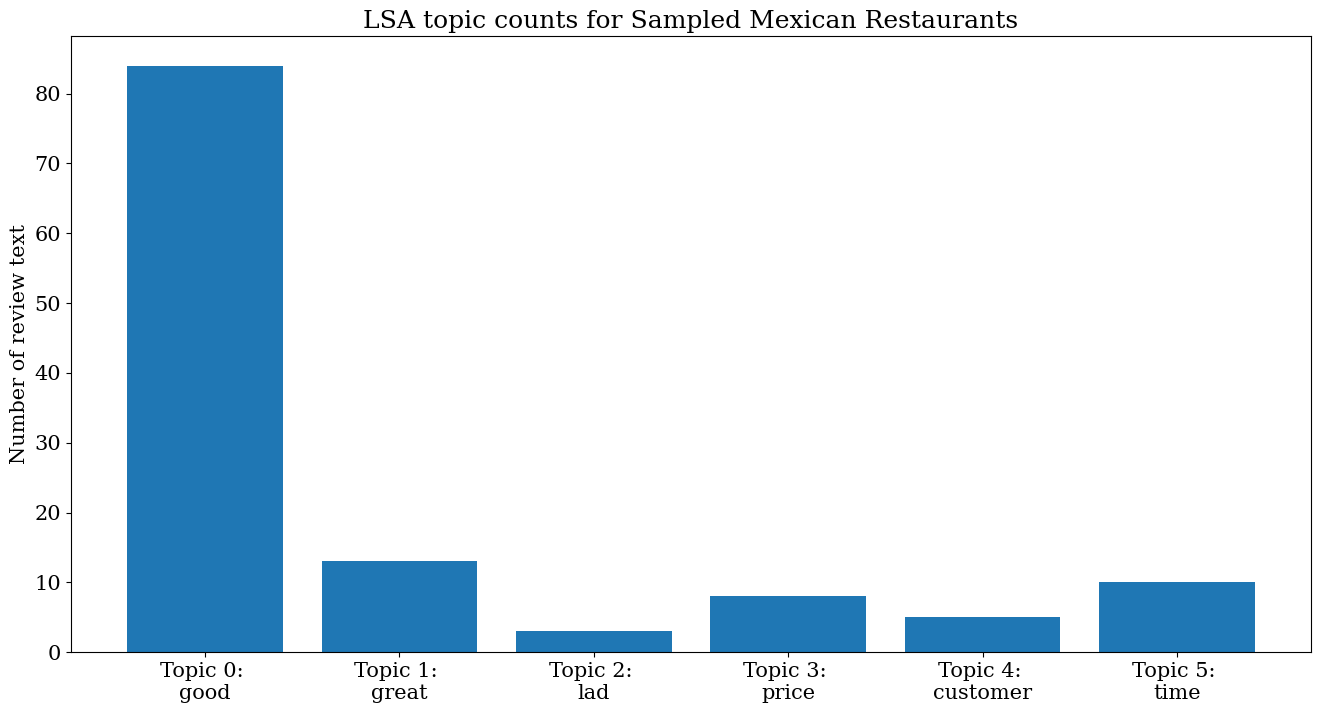

In [70]:
top_3_words = get_top_n_words(1, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts for Sampled Mexican Restaurants');
plt.show();

Not very good interpretation/extraction since Parts of Speech desired should be specified before doing topic modeling and text pre-processing made burrito burr...Trying another method.

In [71]:
# Testing out Algo

# Download NLTK stopwords
# nltk.download('stopwords')

# # Sample Yelp reviews DataFrame
# data = {
#     'review': [
#         "I love the tacos at this place. They're amazing!",
#         "The service was terrible, I will not come back.",
#         "Great atmosphere and friendly staff.",
#         "The food was cold and tasteless.",
#         "I enjoyed my time here, the music was good."
#     ]
# }
# df = pd.DataFrame(data)

# # Preprocess the reviews
# stop_words = set(stopwords.words('english'))
# df['processed'] = df['review'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# # Create a dictionary and corpus
# dictionary = corpora.Dictionary(df['processed'])
# corpus = [dictionary.doc2bow(text) for text in df['processed']]

# # Train the LDA model
# lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# # Print the topics
# topics = lda_model.print_topics(num_words=5)
# for topic in topics:
#     print(topic)

1. Each line represets a different topic.
1. Topic can be inferred by given words, 5 total in this case.
1. Numbers next to words are probability that word would be chosen as topic in newly generated text.
1. These topics also cover adjectives. Need to do entity extraction to zoom-in on core review topics. For example, desired output would have been: food, service, ambiance.

Let's see what ouput is from applying this LDA model to Mexican restaurant reviews. 

In [72]:
stop_words = set(stopwords.words('english'))

test6['processed'] =test6['clean_text2'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# Create a dictionary and corpus
dictionary = corpora.Dictionary(test6['processed'])
corpus = [dictionary.doc2bow(text) for text in test6['processed']]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


(0, '0.015*"food" + 0.009*"tacos" + 0.009*"mexican" + 0.009*"place" + 0.009*"love"')
(1, '0.017*"good" + 0.013*"food" + 0.011*"salsa" + 0.010*"mexican" + 0.008*"chips"')
(2, '0.018*"food" + 0.014*"good" + 0.013*"tacos" + 0.009*"would" + 0.008*"place"')


Once again, best to get parts of speech/aspects from text and then model the topics. Ideally, would want an ouput that mentions food, service and atmosphere topics with adjetives describing each.

In [73]:
# list of tuples with each tuple having unique word in text and its freq

# # Function to clean and tokenize text
# def tokenize(text):
#     # Convert text to lower case
#     text = text.lower()
#     # Remove punctuation and split by whitespace
#     words = re.findall(r'\b\w+\b', text)
#     return words

# # Apply the tokenize function to the text column and create a Counter
# word_counter = Counter()
# test6['clean_text2'].apply(lambda x: word_counter.update(tokenize(x)))

# # Convert the Counter to a list of tuples (word, frequency)
# word_freq = list(word_counter.items())

# # Display the result
# print(word_freq)

References:
1. https://erickleppen.medium.com/topic-modeling-for-beginners-using-bertopic-and-python-aaf1b421afeb
1. ~~https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html~~

Trying out BERTopic model. Will try other methods to get different visualizations of topics.

In [74]:
# Trying BERTopic

docs = test6['clean_text2']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-06-11 16:23:06,846 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2024-06-11 16:23:12,204 - BERTopic - Embedding - Completed ✓
2024-06-11 16:23:12,205 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-11 16:23:23,171 - BERTopic - Dimensionality - Completed ✓
2024-06-11 16:23:23,172 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-11 16:23:23,206 - BERTopic - Cluster - Completed ✓
2024-06-11 16:23:23,210 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-11 16:23:23,326 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,123,-1_tacos_mexican_salsa_chips,"[tacos, mexican, salsa, chips, restaurant, best, burrito, menu, enchiladas, fresh]","[possibly some of the best mexican food i have ever eaten in california i have to thank my fellow yelpers we were driving up from la on highway 101 and decided to pull off to give this place a shot trying to park a long bed f150 4x4 pick up made the stop a little more interesting but we made it happen after getting creative in the back parking lot behind los agaves we came in the back door and found a walk up counter where you order your food from a menu and then are given a number to place on the table the line was about 4 to 5 people deep but went pretty quickly we stepped up and ordered tacos del mar we had to try the fish taco of course but also tried shrimp chicken pork and steak in addition i saw a guy with the wet burrito so i ordered a steak wet burrito to add to our lunch like most couples we order a little bit of this and that and each get to taste several things on the menu they gave us some chips so we wandered over to their cute little salsa bar and got some salsas for the chips and for the tacos since we were driving it was a no on cerveza but if you are chilling they had a decent beer selectionthe food showed up about 10 minutes later the smells were amazing and the food was hot and steamy i loved everything that i tried at los agaves we were pretty lucky because we caught them before the big lunch rush we watched the line get longer and longer as we ate and were grateful that we arrived when we did i wish that we lived closer to this place than 500 miles away because this would be our go to for mexican food next time we are strolling though santa barbara we will definitely pop in here again, we love this place excellent food prices and service great authentic tacos and food our new favorite mexican restaurant, let us hop and skip over to the important parts walk in i really do not pay attention to the decor it is all the same cheesy crap the inside is fairly clean and the bathrooms were spotless staff greets you right away they speak a fair amount of english your seated with menus and complimentary chips n salsa chips and salsa besides the friendly staff the chips and salsa are the first impression chips actually tasted like corn tortillas not that waxy crap you get at some mexican restaurants salsa is where i took a star off because it was nothing special usually i put away the chips and salsa if the salsa is good this i ate some and then was done with it food the menu describes everything and even has a section for definitions if you do not exactly know what a chalupa is i thought that was pretty helpful they have your basics and other specials youll see at other restaurants what i noticed is the prices were good and their food specials do not end at a certain time say before dinner time they are all day long kitchen staff churned out our order pretty quickly i ordered the taco salad and was very pleased with the generous sour cream usually they skimp because it is so costly it also had white shredded cheese and white cheese dip yummy the rest of my party was pleased with their mon night special of 3 tacos rice and beans for 60 dollars yes 60 dollars freaking dollars for all that my husbands steak burrito was large and already drenched in white cheese dip usually you have to pay 10 dollars extra if you want it topped on your burrito overall assessment this place is an a in my book although i cannot vouch for the drinks I am trying to be good the food is top notch to where you do not even need a marg however if you ordered one I am sure it would make this place that much better maybe even make up for the dull salsa]"


* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.
* Let's try another embedder.

In [75]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(test6['clean_text2'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
test6['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-06-11 16:23:44,150 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-11 16:23:47,683 - BERTopic - Dimensionality - Completed ✓
2024-06-11 16:23:47,685 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-11 16:23:47,702 - BERTopic - Cluster - Completed ✓
2024-06-11 16:23:47,706 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-11 16:23:48,107 - BERTopic - Representation - Completed ✓


CPU times: user 19.4 s, sys: 5.3 s, total: 24.7 s
Wall time: 24.4 s


Topic  Count                               Name  \
0     -1     76  -1_tacos_mexican_salsa_restaurant   
1      0     24        0_chips_salsa_ordered_spicy   
2      1     23   1_mexican_best_restaurant_family   

                                                                      Representation  \
0     [tacos, mexican, salsa, restaurant, chips, menu, best, shrimp, la, experience]   
1   [chips, salsa, ordered, spicy, burrito, chicken, taco, asada, restaurant, great]   
2  [mexican, best, restaurant, family, tacos, enchiladas, price, sauce, menu, check]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

These different embeddings create topics that make more sense because selected words per topic have a theme:  service, food

In [76]:
topic_model.get_topic(0)

[('chips', 0.054999511186582764),
 ('salsa', 0.04380671965064824),
 ('ordered', 0.036033532963891675),
 ('spicy', 0.028963994175231093),
 ('burrito', 0.026060971641628218),
 ('chicken', 0.024547049077890046),
 ('taco', 0.02316530812589175),
 ('asada', 0.021277125038751194),
 ('restaurant', 0.020590590265080953),
 ('great', 0.020141323817322122)]

### Trying Bigger dataset (with top 5 restaurants) to get more topics to avoid visualize_topics error

In [77]:
# %%time

# #load the universal sentence encoder model
# use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# #generate embeddings
# use4_embeddings = use4(test5['clean_text'])
# use= np.array(use4_embeddings)

# #create list from np arrays to store the embeddings in the dataframe
# test5['use4'] = use.tolist()

# #pass the embeddings into BERTopic
# topic_model.fit_transform(docs, use)

# #get topic info
# topic_model.get_topic_info()

In [78]:
# from hdbscan import HDBSCAN

# hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', prediction_data=True)
# topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs)

In [79]:
# Visualize topics
# topic_model.visualize_topics()

In [80]:
topic_model.visualize_barchart()

In [81]:
topic_model.visualize_heatmap()

# Aspect Extraction: What is being talked about at the review level? - Topics at a more granular level

In [82]:
# get relevant columns
test7 = test6[['review_id',
 'review_stars',
 'clean_text',
 'hf_sent_label',
 'hf_sent_score',
 'review_id_1',
 'categories',
 'clean_text2']]

In [83]:
test7.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,clean_text2
4,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,OheAhyoKB-wPVV4qFqhKew,"Restaurants, Mexican",delicious authentic mexican food love the carnitas pastor and lengua tongue tacos you cannot go wrong in this place the fajitas and burritos ae great as well try the mole
5,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,u1Yzkm1pc_Zu1e4ehncaLg,"Restaurants, Mexican",the only reason I am giving this joint two stars is the wait i stopped on my way to work as i had quite a bit of time to kill before i had to be in I would heard great things about the breakfast burros so i thought I would give it a try 10am on a weekday i figured it would not be too bad i was wrong 45 minutes from ordering to actually getting my burro to go the burro was great it was not what i ordered but it was tasty the chorizo is really quite good and the beans were excellent it is just a good thing i like chorizo and beans the salsa was also homemade and had a nice slight bite the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that ill probably give them another try on a day when i do not have to be somewhere even if i do have an hour to kill
6,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. you can literally see through them they are so damn thin. and thin = perfection in this case. as a testament to how much i love st. mary's tortillas (and how much my friend's love them as well) i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley. i now have aches and pains in my back and neck, but damn is my belly full of tortilla goodness!!!!",positive,0.997431,ptSIowmXkg2vM1C2Z5mpgA,"Restaurants, Mexican",tucson is full of places to go when you need real key word delicious tortillas this is my favorite because it is easy to find and insanely cheap the tortillas are like magic thin and light you can literally see through them they are so damn thin and thin perfection in this case as a testament to how much i love st marys tortillas and how much my friends love them as well i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley i now have aches and pains in my back and neck but damn is my belly full of tortilla goodness
7,E5KsluLkKmekVbS_C-XHuQ,1.0,"i wash my hands of this ""restaurant"". when i think back to my experience at la terraza i want to cry. waitress some how lost herself along with my order. i asked another waiter for more chips to eat (since my friend was almost done with her meal) and he said, ""find your own waitress"".. i went to say, ""i can't"", but he was already on the other side of the swinging door. also i'm pretty sure their sauce is just ketchup with a smidge of onion and cilantro. i wish this was a jo

# Aspect-based Sentiment Analysis/Opinion Mining
With aspect-based sentiment analysis, can get a better idea on what led to Vader's neg, neutral and pos ratios from each review.

In [84]:
# get small sample of reviews to test algo on
sample = test7.head(5)
sample

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,clean_text2
4,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,OheAhyoKB-wPVV4qFqhKew,"Restaurants, Mexican",delicious authentic mexican food love the carnitas pastor and lengua tongue tacos you cannot go wrong in this place the fajitas and burritos ae great as well try the mole
5,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,u1Yzkm1pc_Zu1e4ehncaLg,"Restaurants, Mexican",the only reason I am giving this joint two stars is the wait i stopped on my way to work as i had quite a bit of time to kill before i had to be in I would heard great things about the breakfast burros so i thought I would give it a try 10am on a weekday i figured it would not be too bad i was wrong 45 minutes from ordering to actually getting my burro to go the burro was great it was not what i ordered but it was tasty the chorizo is really quite good and the beans were excellent it is just a good thing i like chorizo and beans the salsa was also homemade and had a nice slight bite the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that ill probably give them another try on a day when i do not have to be somewhere even if i do have an hour to kill
6,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. you can literally see through them they are so damn thin. and thin = perfection in this case. as a testament to how much i love st. mary's tortillas (and how much my friend's love them as well) i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley. i now have aches and pains in my back and neck, but damn is my belly full of tortilla goodness!!!!",positive,0.997431,ptSIowmXkg2vM1C2Z5mpgA,"Restaurants, Mexican",tucson is full of places to go when you need real key word delicious tortillas this is my favorite because it is easy to find and insanely cheap the tortillas are like magic thin and light you can literally see through them they are so damn thin and thin perfection in this case as a testament to how much i love st marys tortillas and how much my friends love them as well i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley i now have aches and pains in my back and neck but damn is my belly full of tortilla goodness
7,E5KsluLkKmekVbS_C-XHuQ,1.0,"i wash my hands of this ""restaurant"". when i think back to my experience at la terraza i want to cry. waitress some how lost herself along with my order. i asked another waiter for more chips to eat (since my friend was almost done with her meal) and he said, ""find your own waitress"".. i went to say, ""i can't"", but he was already on the other side of the swinging door. also i'm pretty sure their sauce is just ketchup with a smidge of onion and cilantro. i wish this was a jo

### Get Aspects from clean_text. Let us target food, the service, then ambiance

In [85]:
# Let us try HuggingFace model since MonkeyLearn had sign-up/API issues

model_name = "yangheng/deberta-v3-large-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [86]:
aspects = ["food", "service", "ambience"]

text = """
the service was absolutely horrible. 
the restaurant was not very busy, and yet we waited over 1 hour for our food. 
would not recommend if you are expecting good service. 
additionally, the food was very sub par. the draft beer was flat, 
and the other drinks were nothing special. 
would advise elsewhere for mexican food.
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Negative', 'score': 0.8268147110939026}]
service [{'label': 'Negative', 'score': 0.9997759461402893}]
ambience [{'label': 'Negative', 'score': 0.9601736664772034}]


Not sure about negative ambiance since this was not explicitly talked about in review. Let's try others.

In [87]:
aspects = ["food", "service", "ambiance"]

text = """
so we went to this restaurant last night as we were looking for more authentic mexican. 
we'd been there once before when they first opened. 
had to say, we were pretty blown away by how good it was--there were 5 of us, and everything was excellent--literally excellent. 
we had the shrimp ceviche, shrimp tacos, the chicken nachos, chicken burrito, chicken tacos and then the chorizos for dessert (warm, right out of the oven!). 
all were made with fresh ingredients, were of large portion sizes and best of all the seasonings and flavors were superb. 
they brought us a great pitcher of margarita mix (which was excellent as well) and went nicely with our sauza to make great margaritas in the large glasses they provide for them. 
i have to say this is a rare gem of a find, highly worth it, and we are already telling people to go there. total bill for 5 people was $125 too--a real bargain. 
plus the setting was very nice, sitting on the streets of haddonfield, well-shaded. staff/service was on point too--attentive and very prompt. great place.
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Positive', 'score': 0.997377872467041}]
service [{'label': 'Positive', 'score': 0.9996957778930664}]
ambiance [{'label': 'Positive', 'score': 0.9966110587120056}]


This time around, ambiance was mentioned as "setting" and positive sentiment detected.

In [88]:
aspects = ["food", "service", "ambiance"]

text = """
amazing food!!! 
looks like a hole in the wall kind of place but those are always the hidden gems. 
the stuff the tacos, so i was full off of three! 
they were quick and efficient. 
loved it!
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Positive', 'score': 0.9999120235443115}]
service [{'label': 'Positive', 'score': 0.9970831274986267}]
ambiance [{'label': 'Positive', 'score': 0.9277939200401306}]


## Really cool how predictive model was able to determine aspects in review and determine sentiment. 
### Next step is determine what caused aspect sentiment specifically from review. For example, tacos were food aspect that led to positive sentiment for food.

In [89]:
# Maybe get key aspects first that fit under food, service and ambiance. Then get descriptors. And from their classify review with sentiment.

# Trying PyABSA again

In [90]:
# from pyabsa import available_checkpoints
# checkpoint_map = available_checkpoints(from_local=False)

In [91]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

[2024-06-11 16:24:51] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-06-11 16:24:51] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-06-11 16:24:51] (2.4.1.post1) Downloading checkpoint:english 
[2024-06-11 16:24:51] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-06-11 16:25:08] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-06-11 16:25:08] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-06-11 16:25:08] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-06-11 16:25:08] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-06-11 16:25:08] (2.4.1.post1) model: None
[2024-06-11 16:25:08] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-06-11 1

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [92]:
# You can inference from a list of setences or a DatasetItem from PyABSA 
examples = ['Staff was very rude but food was delicious']
inference_source = examples
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

/opt/conda/lib/python3.10/site-packages/pyabsa/tasks/AspectTermExtraction/prediction/aspect_extractor.py:593: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)



[2024-06-11 16:25:18] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 16:25:18] (2.4.1.post1) Example 0: Staff was very rude but <food:Positive Confidence:0.9994> was delicious


In [93]:
atepc_result

[{'sentence': 'Staff was very rude but food was delicious',
  'IOB': ['B-ASP', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O'],
  'tokens': ['Staff',
   'was',
   'very',
   'rude',
   'but',
   'food',
   'was',
   'delicious'],
  'aspect': ['Staff', 'food'],
  'position': [[0], [5]],
  'sentiment': ['Negative', 'Positive'],
  'probs': [[0.9969356060028076, 0.0028198729269206524, 0.0002444849524181336],
   [0.0003258804208599031, 0.0002935871889349073, 0.9993804693222046]],
  'confidence': [0.9969, 0.9994]}]

In [94]:
# Now let us try out couple of the yelp reviews
examples = ['''so we went to this restaurant last night as we were looking for more authentic mexican. 
we'd been there once before when they first opened. 
had to say, we were pretty blown away by how good it was--there were 5 of us, and everything was excellent--literally excellent. 
we had the shrimp ceviche, shrimp tacos, the chicken nachos, chicken burrito, chicken tacos and then the chorizos for dessert (warm, right out of the oven!). 
all were made with fresh ingredients, were of large portion sizes and best of all the seasonings and flavors were superb. 
they brought us a great pitcher of margarita mix (which was excellent as well) and went nicely with our sauza to make great margaritas in the large glasses they provide for them. 
i have to say this is a rare gem of a find, highly worth it, and we are already telling people to go there. total bill for 5 people was $125 too--a real bargain. 
plus the setting was very nice, sitting on the streets of haddonfield, well-shaded. staff/service was on point too--attentive and very prompt. great place.''']

atepc_result2 = aspect_extractor.extract_aspect(inference_source=examples,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

[2024-06-11 16:25:25] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 16:25:25] (2.4.1.post1) Example 0: so we went to this restaurant last night as we were looking for more authentic mexican . we ' d been there once before when they first opened . had to say , we were pretty blown away by how good <it:Positive Confidence:0.9987> was - - there were 5 of us , and everything was excellent - - literally excellent . we had the shrimp <ceviche:Positive Confidence:0.9959> , shrimp tacos , the chicken nachos , chicken burrito , chicken tacos and then the chorizos for dessert ( warm , right out of the oven ! ) . all were made with fresh ingredients , were of large <portion:Positive Confidence:0.9991> sizes and best of all the seasonings and <flavors:Positive Confidence:0.9991> were superb . they brought us a great pitcher of <margarita mix:Positive Confidence:0.9991>

In [95]:
# atepc_result2

In [96]:
# get relevant columns from sample df
query = """
select review_id
, review_stars
, clean_text
, hf_sent_label
, hf_sent_score
, categories
from sample
"""

sample2 = duckdb.query(query).df()
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories
0,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"Restaurants, Mexican"
1,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"Restaurants, Mexican"
2,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. you can literally see through them they are so damn thin. and thin = perfection in this case. as a testament to how much i love st. mary's tortillas (and how much my friend's love them as well) i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley. i now have aches and pains in my back and neck, but damn is my belly full of tortilla goodness!!!!",positive,0.997431,"Restaurants, Mexican"
3,E5KsluLkKmekVbS_C-XHuQ,1.0,"i wash my hands of this ""restaurant"". when i think back to my experience at la terraza i want to cry. waitress some how lost herself along with my order. i asked another waiter for more chips to eat (since my friend was almost done with her meal) and he said, ""find your own waitress"".. i went to say, ""i can't"", but he was already on the other side of the swinging door. also i'm pretty sure their sauce is just ketchup with a smidge of onion and cilantro. i wish this was a joke review, i really do. i also wish i had my $14 bucks back, but nevertheless this place was horrendous. terrible service. on a side note, once i got my food (after the manager asked where it was since i'd been there for 45 minutes).... guess what? it was awful and tasteless. i am a civil person who is generally nice to strangers and my fellow nashvillians, but it's safe to say i ain't coming back to la terraza.",negative,0.987765,"Restaurants, Mexican"
4,aWdv0D3AQwTZ-GOPjlDMJw,5.0,love this place. best mexican restaurant in the south nashville/antioch area. great food and service.,positive,0.997774,"Restaurants, Mexican"


# Add to df general aspects-defined sentiment

In [97]:
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = sample2['clean_text'].apply(analyzer.polarity_scores)

In [98]:
aspects = ["food", "service", "ambience"]

text = """
the service was absolutely horrible. 
the restaurant was not very busy, and yet we waited over 1 hour for our food. 
would not recommend if you are expecting good service. 
additionally, the food was very sub par. the draft beer was flat, 
and the other drinks were nothing special. 
would advise elsewhere for mexican food.
"""
d = {}
for aspect in aspects:
    d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
d

{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}

In [99]:
aspects = ["food", "service", "ambience"]

def absa_general(text):

    d = {}
    for aspect in aspects:
        d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
    return d

sample2['absa_gen'] = sample2.apply(lambda row: absa_general(row['clean_text']), axis=1)

In [100]:
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen
0,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}"
1,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Negative', 'ambience': 'Positive'}"
2,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. you can literally see through them they are so damn thin. and thin = perfection in this case. as a testament to how much i love st. mary's tortillas (and how much my friend's love them as well) i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley. i now have aches and pains in my back and neck, but damn is my belly full of tortilla goodness!!!!",positive,0.997431,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Neutral'}"
3,E5KsluLkKmekVbS_C-XHuQ,1.0,"i wash my hands of this ""restaurant"". when i think back to my experience at la terraza i want to cry. waitress some how lost herself along with my order. i asked another waiter for more chips to eat (since my friend was almost done with her meal) and he said, ""find your own waitress"".. i went to say, ""i can't"", but he was already on the other side of the swinging door. also i'm pretty sure their sauce is just ketchup with a smidge of onion and cilantro. i wish this was a joke review, i really do. i also wish i had my $14 bucks back, but nevertheless this place was horrendous. terrible service. on a side note, once i got my food (after the manager asked where it was since i'd been there for 45 minutes).... guess what? it was awful and tasteless. i am a civil person who is generally nice to strangers and my fellow nashvillians, but it's safe to say i ain't coming back to la terraza.",negative,0.987765,"Restaurants, Mexican","{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}"
4,aWdv0D3AQwTZ-GOPjlDMJw,5.0,love this place. best mexican restaurant in the south nashville/antioch area. great food and service.,positive,0.997774,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}"


In [101]:
# Extract keys and create new columns
for key in sample2['absa_gen'][0].keys():
    sample2[key] = sample2['absa_gen'].apply(lambda x: x[key])

# Display the updated DataFrame
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience
0,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive
1,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Negative', 'ambience': 'Positive'}",Positive,Negative,Positive
2,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. you can literally see through them they are so damn thin. and thin = perfection in this case. as a testament to how much i love st. mary's tortillas (and how much my friend's love them as well) i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley. i now have aches and pains in my back and neck, but damn is my belly full of tortilla goodness!!!!",positive,0.997431,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Neutral'}",Positive,Positive,Neutral
3,E5KsluLkKmekVbS_C-XHuQ,1.0,"i wash my hands of this ""restaurant"". when i think back to my experience at la terraza i want to cry. waitress some how lost herself along with my order. i asked another waiter for more chips to eat (since my friend was almost done with her meal) and he said, ""find your own waitress"".. i went to say, ""i can't"", but he was already on the other side of the swinging door. also i'm pretty sure their sauce is just ketchup with a smidge of onion and cilantro. i wish this was a joke review, i really do. i also wish i had my $14 bucks back, but nevertheless this place was horrendous. terrible service. on a side note, once i got my food (after the manager asked where it was since i'd been there for 45 minutes).... guess what? it was awful and tasteless. i am a civil person who is generally nice to strangers and my fellow nashvillians, but it's safe to say i ain't coming back to la terraza.",negative,0.987765,"Restaurants, Mexican","{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}",Negative,Negative,Negative
4,aWdv0D3AQwTZ-GOPjlDMJw,5.0,love this place. best mexican restaurant in the south nashville/antioch area. great food and service.,positive,0.997774,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive


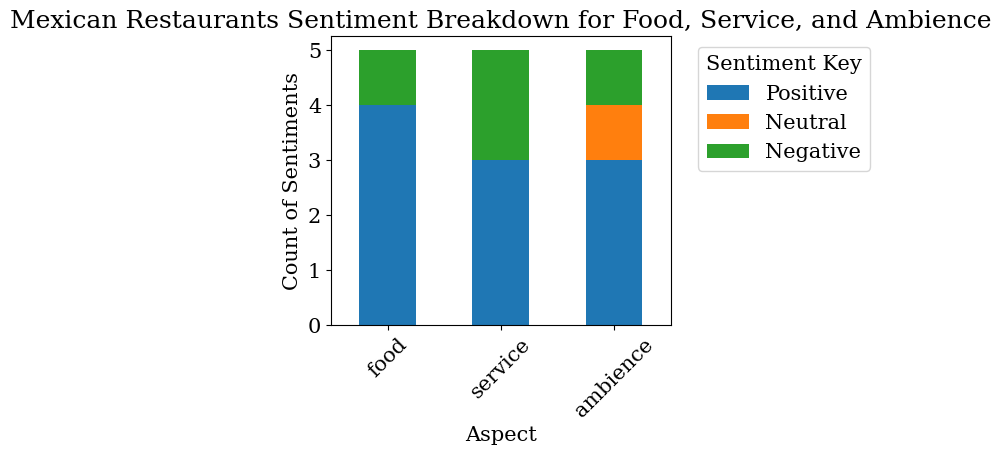

In [102]:
# Extract keys and create new columns
for key in sample2['absa_gen'][0].keys():
    sample2[key] = sample2['absa_gen'].apply(lambda x: x[key])

# Count occurrences of each sentiment for food, service, and ambience
sentiments = ['Positive', 'Neutral', 'Negative']
aspects = ['food', 'service', 'ambience']

# Initialize an empty dictionary to hold the sentiment counts
sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# Populate the sentiment counts
for aspect in aspects:
    counts = sample2[aspect].value_counts()
    for sentiment in sentiments:
        if sentiment in counts:
            sentiment_counts[aspect][sentiment] = counts[sentiment]

# Create a DataFrame from sentiment counts
sentiment_df = pd.DataFrame(sentiment_counts)

# Plot the stacked bar chart
sentiment_df.T.plot(kind='bar', stacked=True)

# Customize the chart
plt.title('Mexican Restaurants Sentiment Breakdown for Food, Service, and Ambience')
plt.xlabel('Aspect')
plt.ylabel('Count of Sentiments')
plt.xticks(rotation=45)

# Place the legend outside the plot
plt.legend(title='Sentiment Key', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

# Add PyABSA on sample's reviews

In [103]:
# You can inference from a list of setences or a DatasetItem from PyABSA 
examples = ['Staff was very rude but food was delicious']
inference_source = examples
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

[2024-06-11 16:25:54] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 16:25:54] (2.4.1.post1) Example 0: Staff was very rude but <food:Positive Confidence:0.9994> was delicious


In [104]:
atepc_result[0].get('aspect')

['Staff', 'food']

In [105]:
atepc_result[0].get('sentiment')

['Negative', 'Positive']

In [106]:
dict(zip(atepc_result[0].get('aspect'), atepc_result[0].get('sentiment')))

{'Staff': 'Negative', 'food': 'Positive'}

In [107]:
test_d = dict(zip(atepc_result2[0].get('aspect'), atepc_result2[0].get('sentiment')))
test_d['music'] = 'Neutral'
test_d

{'ceviche': 'Positive',
 'portion': 'Positive',
 'flavors': 'Positive',
 'margarita mix': 'Positive',
 'it': 'Positive',
 'setting': 'Positive',
 'staff': 'Positive',
 'service': 'Positive',
 'music': 'Neutral'}

In [108]:
grouped_dict = {}

for key, value in test_d.items():
    if value not in grouped_dict:
        grouped_dict[value] = [key]
    else:
        grouped_dict[value].append(key)

# Convert keys into combined strings
grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}

grouped_dict

{'ceviche, portion, flavors, margarita mix, it, setting, staff, service': 'Positive',
 'music': 'Neutral'}

In [109]:
# Run Pandas review row through PyABSA
sample2.head(1)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience
0,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive


In [110]:
# Make sure new dict created with aspects and sentiments
def absa_sp(text):

    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )
    aspect = atepc_result[0].get('aspect')
    sentiment = atepc_result[0].get('sentiment')
    new_dict = dict(zip(sentiment, aspect)) #swap this to use chatgpt 3.5/try gemini
    
    grouped_dict = {} # Create final ditionary that aggregates words to grouped by sentiment

    for key, value in new_dict.items():
        if value not in grouped_dict:
            grouped_dict[value] = [key]
        else:
            grouped_dict[value].append(key)

    # Convert keys into combined strings
    grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
    return grouped_dict


sample2['absa_sp'] = sample2['clean_text'].apply(lambda x: absa_sp([x]))

[2024-06-11 16:26:01] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 16:26:01] (2.4.1.post1) Example 0: delicious authentic <mexican food:Positive Confidence:0.9994> ! love the <carnitas:Positive Confidence:0.9985> , <pastor:Positive Confidence:0.968> and lengua <(:Positive Confidence:0.9338> tongue <) tacos:Neutral Confidence:0.6041> . you can ' t go wrong in this place . . . the fajitas and <burritos:Positive Confidence:0.9984> ae great as well ! try the mole !
[2024-06-11 16:26:09] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 16:26:09] (2.4.1.post1) Example 0: the only reason i ' m giving this joint two stars is the <wait:Negative Confidence:0.9929> . i stopped on my way to work , as i had quite a bit of time to kill before i

In [111]:
sample2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience,absa_sp
0,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'Positive': 'burritos', 'Neutral': ') tacos'}"
1,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Negative', 'ambience': 'Positive'}",Positive,Negative,Positive,"{'Negative': 'ordering', 'Positive': 'tres leches cake'}"
2,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. you can literally see through them they are so damn thin. and thin = perfection in this case. as a testament to how much i love st. mary's tortillas (and how much my friend's love them as well) i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley. i now have aches and pains in my back and neck, but damn is my belly full of tortilla goodness!!!!",positive,0.997431,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Neutral'}",Positive,Positive,Neutral,{'Positive': 'mary'}
3,E5KsluLkKmekVbS_C-XHuQ,1.0,"i wash my hands of this ""restaurant"". when i think back to my experience at la terraza i want to cry. waitress some how lost herself along with my order. i asked another waiter for more chips to eat (since my friend was almost done with her meal) and he said, ""find your own waitress"".. i went to say, ""i can't"", but he was already on the other side of the swinging door. also i'm pretty sure their sauce is just ketchup with a smidge of onion and cilantro. i wish this was a joke review, i really do. i also wish i had my $14 bucks back, but nevertheless this place was horrendous. terrible service. on a side note, once i got my food (after the manager asked where it was since i'd been there for 45 minutes).... guess what? it was awful and tasteless. i am a civil person who is generally nice to strangers and my fellow nashvillians, but it's safe to say i ain't coming back to la terraza.",negative,0.987765,"Restaurants, Mexican","{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}",Negative,Negative,Negative,{'Negative': 'minutes'}
4,aWdv0D3AQwTZ-GOPjlDMJw,5.0,love this place. best mexican restaurant in the south nashville/antioch area. great food and service.,positive,0.997774,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{'Positive': 'service'}


In [112]:
# Function to expand absa_sp dictionary into separate columns
def expand_absa_sp(row):
    result = {}
    for key, value in row.items():
        result[key] = value
    return pd.Series(result)

# Apply the function to the absa_sp column
expanded_columns = sample2['absa_sp'].apply(expand_absa_sp)

# Concatenate the original DataFrame with the expanded columns
sample2 = pd.concat([sample2, expanded_columns], axis=1)

# Change NaN to None 
sample2 = sample2.replace({np.nan: None})
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience,absa_sp,Positive,Neutral,Negative
0,OheAhyoKB-wPVV4qFqhKew,5.0,"delicious authentic mexican food! love the carnitas, pastor and lengua (tongue) tacos. you can't go wrong in this place... the fajitas and burritos ae great as well! try the mole!",positive,0.998042,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'Positive': 'burritos', 'Neutral': ') tacos'}",burritos,) tacos,None
1,u1Yzkm1pc_Zu1e4ehncaLg,2.0,"the only reason i'm giving this joint two stars is the wait. i stopped on my way to work, as i had quite a bit of time to kill before i had to be in; i'd heard great things about the breakfast burros, so i thought i'd give it a try. 10am on a weekday, i figured it wouldn't be too bad. i was wrong. 45 minutes from ordering to actually getting my burro to go. the burro was great. it wasn't what i ordered, but it was tasty. the chorizo is really quite good, and the beans were excellent. it's just a good thing i like chorizo and beans. the salsa was also homemade and had a nice, slight bite. the tres leches cake that they were cutting up and packaging in the back made me wish i had ordered that. i'll probably give them another try, on a day when i don't have to be somewhere, even if i do have an hour to kill.",positive,0.870337,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Negative', 'ambience': 'Positive'}",Positive,Negative,Positive,"{'Negative': 'ordering', 'Positive': 'tres leches cake'}",tres leches cake,None,ordering
2,ptSIowmXkg2vM1C2Z5mpgA,5.0,"tucson is full of places to go when you need real (key word), delicious tortillas. this is my favorite because it's easy to find and insanely cheap. the tortillas are like magic, thin and light. you can literally see through them they are so damn thin. and thin = perfection in this case. as a testament to how much i love st. mary's tortillas (and how much my friend's love them as well) i carried what felt like a 20lb tortilla baby in my backpack from tucson to berkeley. i now have aches and pains in my back and neck, but damn is my belly full of tortilla goodness!!!!",positive,0.997431,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Neutral'}",Positive,Positive,Neutral,{'Positive': 'mary'},mary,None,None
3,E5KsluLkKmekVbS_C-XHuQ,1.0,"i wash my hands of this ""restaurant"". when i think back to my experience at la terraza i want to cry. waitress some how lost herself along with my order. i asked another waiter for more chips to eat (since my friend was almost done with her meal) and he said, ""find your own waitress"".. i went to say, ""i can't"", but he was already on the other side of the swinging door. also i'm pretty sure their sauce is just ketchup with a smidge of onion and cilantro. i wish this was a joke review, i really do. i also wish i had my $14 bucks back, but nevertheless this place was horrendous. terrible service. on a side note, once i got my food (after the manager asked where it was since i'd been there for 45 minutes).... guess what? it was awful and tasteless. i am a civil person who is generally nice to strangers and my fellow nashvillians, but it's safe to say i ain't coming back to la terraza.",negative,0.987765,"Restaurants, Mexican","{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}",Negative,Negative,Negative,{'Negative': 'minutes'},None,None,minutes
4,aWdv0D3AQwTZ-GOPjlDMJw,5.0,love this place. best mexican restaurant in the south nashville/antioch area. great food and service.,positive,0.997774,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{'Positive': 'service'},service,None,None


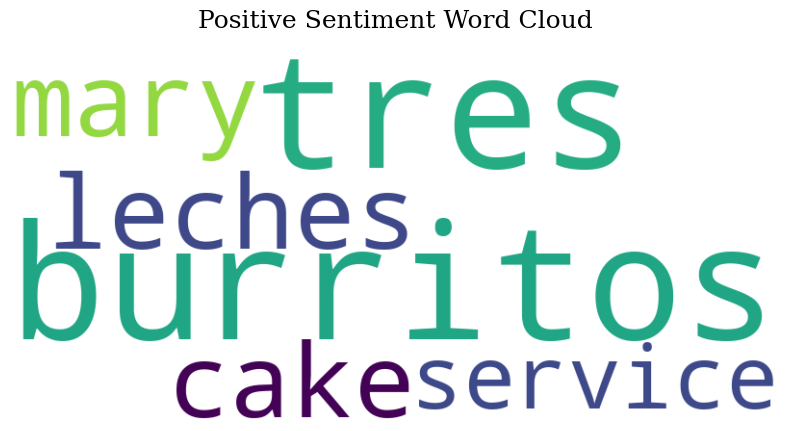

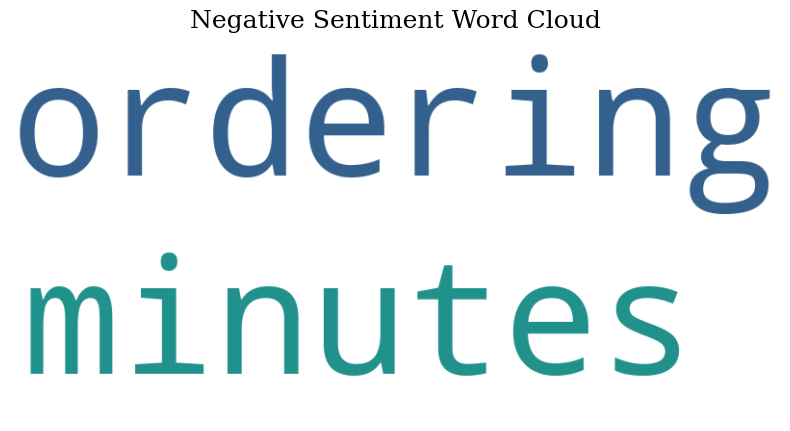

In [113]:
# Create wordclouds for each sentiment

# Function to generate word cloud
def generate_wordcloud(column_data, title):
    text = ' '.join(filter(None, column_data))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment
generate_wordcloud(sample2['Positive'], 'Positive Sentiment Word Cloud')
# generate_wordcloud(sample2['Neutral'], 'Neutral Sentiment Word Cloud')
generate_wordcloud(sample2['Negative'], 'Negative Sentiment Word Cloud')

### Can create recommendations for restaurants on what they have been doing well and room for improvement

Looks like Mexican restaurants are doing well with: green salsa and tacos and  need to work on: the beer, salsa and environment. 